# 0.1 Bibliotecas

In [1]:
#bibliotecas
import pandas         as pd
import numpy          as np
import seaborn        as sns
import inflection
import re
from datetime import datetime

from matplotlib  import pyplot           as plt
from scipy.stats import chi2_contingency as chisq
from statsmodels.graphics.tsaplots import plot_acf as plt_acf
from statsmodels.graphics.tsaplots import plot_pacf

# 0.2 Funções de suporte

In [2]:
def tab_freq(data, var, ordem_var = False):    
    #freq abs
    data_summary = data.groupby(var).size().reset_index(name='freq_abs')
    
    #freq rel
    data_summary["freq_rel"] = (data.groupby(var).size().reset_index(name='counts')["counts"]/len(data))

    if ordem_var != False: 
        data_summary["order_var"] = data_summary[var].map( ordem_var )
        data_summary = data_summary.sort_values("order_var").reset_index()
    
    
    #freq acum
    sum_acum = 0 
    x1_sum_acum = []    
    for i in list(range(len(data_summary))):
             sum_acum = sum_acum + data_summary["freq_rel"][i]
             x1_sum_acum.append(sum_acum)

    data_summary["freq_acum"] = x1_sum_acum
    
    if ordem_var != False:
        data_summary = data_summary[[var,'freq_abs',"freq_rel","freq_acum"]]
    
    return data_summary

def densityplot_quali_quanti(data, var_quanti, var_quali):
    data_wide = data[[var_quanti,var_quali]].pivot(columns = var_quali,
                     values = var_quanti)
    # plotting multiple density plot
    return (data_wide.plot.kde())

def r_quad(data,var2,var1):
    var_tab = data.groupby(var1)[var2].agg('var').reset_index(name = var2)
    var_tab["freq"] = data.groupby(var1).size().reset_index(name = "Freq")["Freq"]
    var_tab["freq_rel"] = var_tab["freq"]/len(data[var1])
    var_pond = (var_tab["freq_rel"]*var_tab[var2]).reset_index(name = "var_pond")["var_pond"].sum()
    var_geral = data[var2].var()
    r_quad = 1 - var_pond/var_geral
    return r_quad

def tab_cont(data, var1, var2, ordem_var = False):
    aux1 = data.groupby([var1,var2]).size().reset_index(name="freq")
    aux1["freq_rel"] = aux1["freq"]/len(data)
    
    if ordem_var != False: 
        aux1["order_var"] = aux1[var2].map( ordem_var )
        aux1 = aux1.sort_values("order_var").reset_index()
        aux1 = aux1.drop(columns=["order_var"])
    
    aux2 = aux1.pivot(index=var1, columns=var2, values="freq")
    aux3 = aux1.pivot(index=var1, columns=var2, values="freq_rel")
    
    aux3.columns = aux3.columns + "_perc"
    
    aux = pd.concat([aux2, aux3], axis = 1)
    
    return aux

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Magalhaes\anaconda3\envs\supermarketSales\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1. Entendimento do negócio

## 1.1. Contexto 

* Crescimento de supermercados nas grandes cidades
* Aumento da competição entre os players do mercado

(https://www.kaggle.com/aungpyaeap/supermarket-sales)

## 1.2. Objetivos

* <b>Aumentar as vendas</b>    
* <b>Aumentar a satisfação dos clientes na realização de suas compras</b>
* <b>Aumentar o número de clientes membros</b> - Considerando que é vantajoso ter clientes membros, pois espera-se, que eles comprem com mais frequência    


## 1.3. Premissas


* The dataset is one of the historical sales of supermarket company which has recorded in 3 different branches for 3 months data
* A base de dados representa todos os registros de vendas do supermercado nos três primeiros meses de 2019, ou seja, não é uma amostra ou uma base filtrada de alguma maneira (obs.: base não parece ser real);
* Outras informações não estão imediatamente disponíveis, então outras variáveis que poderiam complementar a análise serão implementadas em atualizações futuras do dashboard e desta análise

## 1.4. Riscos

Em relação ao negócio:
* Não crescer em receitas
* Não entender o comportamento de compra dos consumidores (produtos mais comprados, relação preço x quantidade de produtos comprados) 
* Não ser reconhecido como um estabelecimento que satisfaz seus clientes
* Não conseguir fidelizar seus clientes e por isso aumentar o risco de que os clientes sejam captados pela concorrência

Em relação aos dados:
* Dados não serem a fotografia completa do processo de vendas
* Informação incosistente 


## 1.5. Custos

* Para um projeto como este considera-se como custos diretos:
    * Tempo hora de trabalho do analista de dados
    * Licença do PowerBi para implementação do dashboard (principalmente se considerada a necessidade de publicação com conta Premium)
    
* Já a não implementação do projeto pode causar a perda de receita pelo não entendimento da dinâmica de compra dos produtos oferecidos pelo supermercado


## 1.6. Critérios de sucesso

* Construir um painel de uma página com as métricas mais relevantes

## 1.8. Planejamento

* Usar metodologia CRISP-DM
* Fazer análise inicial em python utilizando jupyter notebook para tratar a base e identificar a relação entre as variáveis
* Com a base tratada e as relações entre as variáveis identificadas, construir dashboard em PowerBi para acompanhamento das métricas 

# 2. Entendimento dos dados

## 2.1. Coleta dos dados

Dados do dataset (https://www.kaggle.com/aungpyaeap/supermarket-sales)
Download feito e arquivo salvo localmente depois do unzip

In [4]:
df2 = pd.read_csv("../data/supermarket_sales.csv")

In [5]:
df2.sample(6)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
552,210-57-1719,B,Mandalay,Normal,Female,Health and beauty,58.24,9,26.208,550.368,2/5/2019,12:34,Cash,524.16,4.761905,26.208,9.7
300,446-47-6729,C,Naypyitaw,Normal,Male,Fashion accessories,99.82,2,9.982,209.622,1/2/2019,18:09,Credit card,199.64,4.761905,9.982,6.7
558,712-39-0363,A,Yangon,Member,Male,Food and beverages,41.66,6,12.498,262.458,1/2/2019,15:24,Ewallet,249.96,4.761905,12.498,5.6
889,880-46-5796,A,Yangon,Member,Male,Sports and travel,76.92,10,38.460,807.660,3/17/2019,19:53,Ewallet,769.20,4.761905,38.460,5.6
410,244-08-0162,B,Mandalay,Normal,Female,Health and beauty,34.21,10,17.105,359.205,1/2/2019,13:00,Cash,342.10,4.761905,17.105,5.1
567,651-88-7328,A,Yangon,Normal,Female,Fashion accessories,65.74,9,29.583,621.243,1/1/2019,13:55,Cash,591.66,4.761905,29.583,7.7


## 2.2. Descrição dos dados

### 2.2.0. Metadados 

* <b>Invoice id:</b> Computer generated sales slip invoice identification number
* <b>Branch:</b> Branch of supercenter (3 branches are available identified by A, B and C).
* <b>City:</b> Location of supercenters
* <b>Customer type:</b> Type of customers, recorded by Members for customers using member card and Normal for without member card.
* <b>Gender:</b> Gender type of customer
* <b>Product line:</b> General item categorization groups - Electronic accessories, Fashion accessories, Food and beverages, Health and beauty, Home and lifestyle, Sports and travel
* <b>Unit price:</b> Price of each product in USD
* <b>Quantity:</b> Number of products purchased by customer
* <b>Tax:</b> 5% tax fee for customer buying
* <b>Total:</b> Total price including tax
* <b>Date:</b> Date of purchase (Record available from January 2019 to March 2019)
* <b>Time:</b> Purchase time (10am to 9pm)
* <b>Payment:</b> Payment used by customer for purchase (3 methods are available – Cash, Credit card and Ewallet)
* <b>COGS:</b> Cost of goods sold
* <b>Gross margin percentage:</b> Gross margin percentage
* <b>Gross income:</b> Gross income
* <b>Rating:</b> Customer stratification rating on their overall shopping experience (On a scale of 1 to 10)

### 2.2.1. Renomear variáveis

In [6]:
cols_old = list(df2.columns)
snakecase = lambda x: re.sub("%","_perc",re.sub(" ","_",inflection.underscore( x )))
cols_new = list( map( snakecase, cols_old ) )
cols_new
# rename
df2.columns = cols_new
df2.columns

Index(['invoice_id', 'branch', 'city', 'customer_type', 'gender',
       'product_line', 'unit_price', 'quantity', 'tax_5_perc', 'total', 'date',
       'time', 'payment', 'cogs', 'gross_margin_percentage', 'gross_income',
       'rating'],
      dtype='object')

In [7]:
df2['date_time'] = df2['date'] + ' ' + df2['time']

In [8]:
df2.sample(10)

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5_perc,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating,date_time
384,662-72-2873,A,Yangon,Normal,Female,Food and beverages,40.94,5,10.2350,214.9350,1/6/2019,13:58,Ewallet,204.70,4.761905,10.2350,9.9,1/6/2019 13:58
611,277-35-5865,C,Naypyitaw,Member,Female,Food and beverages,98.97,9,44.5365,935.2665,3/9/2019,11:23,Cash,890.73,4.761905,44.5365,6.7,3/9/2019 11:23
692,689-05-1884,A,Yangon,Member,Male,Health and beauty,48.63,10,24.3150,510.6150,3/4/2019,12:44,Cash,486.30,4.761905,24.3150,8.8,3/4/2019 12:44
802,474-33-8305,C,Naypyitaw,Member,Male,Fashion accessories,67.39,7,23.5865,495.3165,3/23/2019,13:23,Ewallet,471.73,4.761905,23.5865,6.9,3/23/2019 13:23
706,834-45-5519,B,Mandalay,Normal,Female,Electronic accessories,43.00,4,8.6000,180.6000,1/31/2019,20:48,Ewallet,172.00,4.761905,8.6000,7.6,1/31/2019 20:48
499,420-18-8989,A,Yangon,Member,Female,Sports and travel,51.52,8,20.6080,432.7680,2/2/2019,15:47,Cash,412.16,4.761905,20.6080,9.6,2/2/2019 15:47
569,408-26-9866,C,Naypyitaw,Normal,Female,Sports and travel,73.98,7,25.8930,543.7530,3/2/2019,16:42,Ewallet,517.86,4.761905,25.8930,4.1,3/2/2019 16:42
171,316-55-4634,B,Mandalay,Member,Male,Food and beverages,80.05,5,20.0125,420.2625,1/26/2019,12:45,Credit card,400.25,4.761905,20.0125,9.4,1/26/2019 12:45
411,569-71-4390,B,Mandalay,Normal,Male,Sports and travel,21.87,2,2.1870,45.9270,1/25/2019,14:29,Ewallet,43.74,4.761905,2.1870,6.9,1/25/2019 14:29
121,659-36-1684,C,Naypyitaw,Member,Male,Sports and travel,57.12,7,19.9920,419.8320,1/12/2019,12:02,Credit card,399.84,4.761905,19.9920,6.5,1/12/2019 12:02


### 2.2.2. Dimensoes dos dados

In [9]:
print( 'Number of Rows: {}'.format( df2.shape[0] ) )
print( 'Number of Cols: {}'.format( df2.shape[1] ) )

Number of Rows: 1000
Number of Cols: 18


### 2.2.3. Tipos de variaveis

In [10]:
df2.dtypes

invoice_id                  object
branch                      object
city                        object
customer_type               object
gender                      object
product_line                object
unit_price                 float64
quantity                     int64
tax_5_perc                 float64
total                      float64
date                        object
time                        object
payment                     object
cogs                       float64
gross_margin_percentage    float64
gross_income               float64
rating                     float64
date_time                   object
dtype: object

#### 2.2.3.1. Mudando tipo de variáveis

In [11]:
#df2['date'] = pd.to_datetime( df2['date'] , format = '%m/%d/%Y' ) 
df2['date_time'] = pd.to_datetime( df2['date_time'] , format = '%m/%d/%Y %H:%M' ) 

In [12]:
df2 = df2.drop('date',axis='columns')
df2 = df2.drop('time',axis='columns')
df2.sample(10)

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5_perc,total,payment,cogs,gross_margin_percentage,gross_income,rating,date_time
338,633-09-3463,C,Naypyitaw,Normal,Female,Electronic accessories,47.65,3,7.1475,150.0975,Credit card,142.95,4.761905,7.1475,9.5,2019-03-28 12:58:00
250,845-51-0542,B,Mandalay,Member,Male,Food and beverages,46.55,9,20.9475,439.8975,Ewallet,418.95,4.761905,20.9475,6.4,2019-02-02 15:34:00
558,712-39-0363,A,Yangon,Member,Male,Food and beverages,41.66,6,12.4980,262.4580,Ewallet,249.96,4.761905,12.4980,5.6,2019-01-02 15:24:00
698,868-06-0466,A,Yangon,Member,Male,Electronic accessories,69.58,9,31.3110,657.5310,Credit card,626.22,4.761905,31.3110,7.8,2019-02-19 19:38:00
143,488-25-4221,C,Naypyitaw,Member,Female,Food and beverages,30.41,1,1.5205,31.9305,Credit card,30.41,4.761905,1.5205,8.4,2019-02-22 10:36:00
272,126-54-1082,A,Yangon,Member,Female,Home and lifestyle,21.54,9,9.6930,203.5530,Credit card,193.86,4.761905,9.6930,8.8,2019-01-07 11:44:00
991,602-16-6955,B,Mandalay,Normal,Female,Sports and travel,76.60,10,38.3000,804.3000,Ewallet,766.00,4.761905,38.3000,6.0,2019-01-24 18:10:00
937,361-85-2571,A,Yangon,Normal,Female,Sports and travel,89.48,5,22.3700,469.7700,Cash,447.40,4.761905,22.3700,7.4,2019-03-30 10:18:00
872,544-55-9589,B,Mandalay,Member,Female,Electronic accessories,21.43,10,10.7150,225.0150,Cash,214.30,4.761905,10.7150,6.2,2019-01-28 11:51:00
656,250-81-7186,C,Naypyitaw,Normal,Female,Electronic accessories,99.69,1,4.9845,104.6745,Credit card,99.69,4.761905,4.9845,8.0,2019-02-27 10:23:00


#### 2.2.3.2. Checar NA

In [13]:
df2.isna().sum()

invoice_id                 0
branch                     0
city                       0
customer_type              0
gender                     0
product_line               0
unit_price                 0
quantity                   0
tax_5_perc                 0
total                      0
payment                    0
cogs                       0
gross_margin_percentage    0
gross_income               0
rating                     0
date_time                  0
dtype: int64

## 2.3. Análise exploratória

### 2.3.1. Análise unidimensional

In [14]:
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

#### 2.3.1.2. Variáveis quantitativas

In [15]:
# Medidas de posição
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Medidas de dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,unit_price,10.080000,99.960000,89.8800,55.672130,55.230000,2.648138e+01,0.007077,-1.218591
1,quantity,1.000000,10.000000,9.0000,5.510000,5.000000,2.921969e+00,0.012941,-1.215547
2,tax_5_perc,0.508500,49.650000,49.1415,15.379369,12.088000,1.170297e+01,0.892570,-0.081885
3,total,10.678500,1042.650000,1031.9715,322.966749,253.848000,2.457624e+02,0.892570,-0.081885
4,cogs,10.170000,993.000000,982.8300,307.587380,241.760000,2.340594e+02,0.892570,-0.081885
5,gross_margin_percentage,4.761905,4.761905,0.0000,4.761905,4.761905,6.128431e-14,0.000000,0.000000
6,gross_income,0.508500,49.650000,49.1415,15.379369,12.088000,1.170297e+01,0.892570,-0.081885
7,rating,4.000000,10.000000,6.0000,6.972700,7.000000,1.717721e+00,0.009010,-1.151587


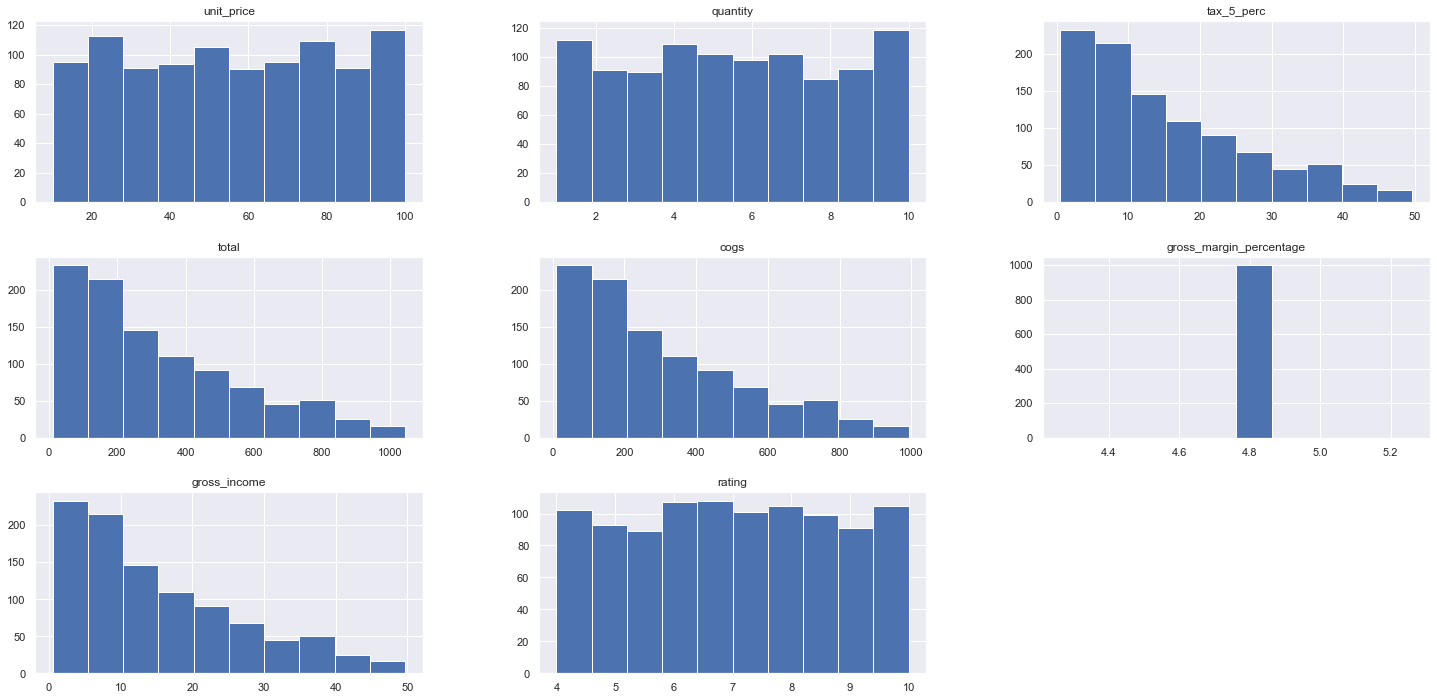

In [16]:
num_attributes.hist();
#num_attributes[['unit_price','quantity','rating']].hist();

gross_margin_percentage é constante 
* unit_price, quantity, rating se aproximam de uma distribuição uniforme


#### 2.3.1.2. Variáveis qualitativas

In [17]:
list(cat_attributes.columns)

['invoice_id',
 'branch',
 'city',
 'customer_type',
 'gender',
 'product_line',
 'payment']

In [18]:
tab_freq(df2, "branch")

,branch,freq_abs,freq_rel,freq_acum
0,A,340,0.340,0.340
1,B,332,0.332,0.672
2,C,328,0.328,1.000


In [19]:
tab_freq(df2, "city")

,city,freq_abs,freq_rel,freq_acum
0,Mandalay,332,0.332,0.332
1,Naypyitaw,328,0.328,0.660
2,Yangon,340,0.340,1.000


Pesquisando a localização das cidades descobre-se que elas estão na India e que a escrita correta de Naypyitaw é na verdade Naypyidaw. 

In [20]:
df2.loc[df2['city'] == "Naypyitaw", ['city']] = "Naypyidaw"

In [21]:
tab_freq(df2, "customer_type")

,customer_type,freq_abs,freq_rel,freq_acum
0,Member,501,0.501,0.501
1,Normal,499,0.499,1.000


In [22]:
tab_freq(df2, "gender")

,gender,freq_abs,freq_rel,freq_acum
0,Female,501,0.501,0.501
1,Male,499,0.499,1.000


In [23]:
tab_freq(df2, "product_line").sort_values('freq_abs', ascending = False)

,product_line,freq_abs,freq_rel,freq_acum
1,Fashion accessories,178,0.178,0.348
2,Food and beverages,174,0.174,0.522
0,Electronic accessories,170,0.170,0.170
5,Sports and travel,166,0.166,1.000
4,Home and lifestyle,160,0.160,0.834
3,Health and beauty,152,0.152,0.674


In [24]:
tab_freq(df2, "payment").sort_values('freq_abs', ascending = False)

,payment,freq_abs,freq_rel,freq_acum
2,Ewallet,345,0.345,1.000
0,Cash,344,0.344,0.344
1,Credit card,311,0.311,0.655


### 2.3.2. Análise bidimensional

#### 2.3.2.1. Variáveis quantitativas vs Variáveis quantitativas

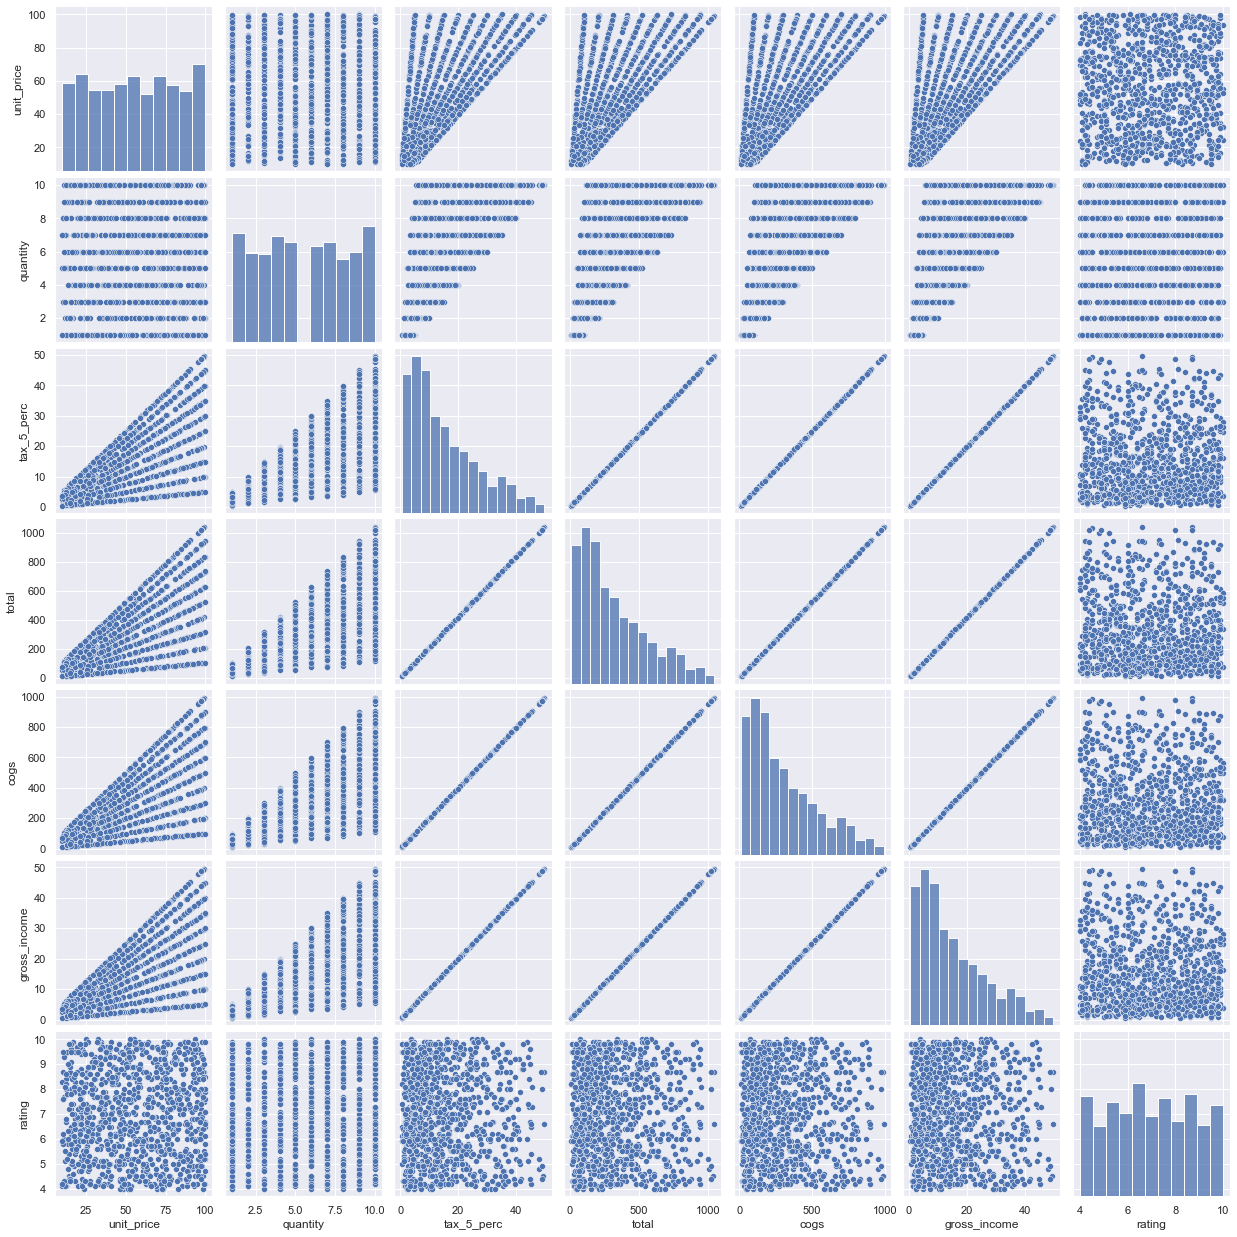

In [25]:
sns.pairplot(df2.drop('gross_margin_percentage', axis = 1))

<b>Conclusões:</b>
* total vs cogs vs gross_income vs tax_5_perc possuem relacoes lineares diretas, ou seja, nao aleatorias
* unit_price vs quantity aparatemente não há relação (normalmente esperamos que quanto maior o preço, menor seja o volume de vendas)
* rating (aparetemente não tem uma relação direta com nenhuma variável) 

#### 2.3.2.2. Variáveis qualitativas vs Variáveis quantitativas (quantidade, total e rating)

<AxesSubplot:ylabel='Density'>

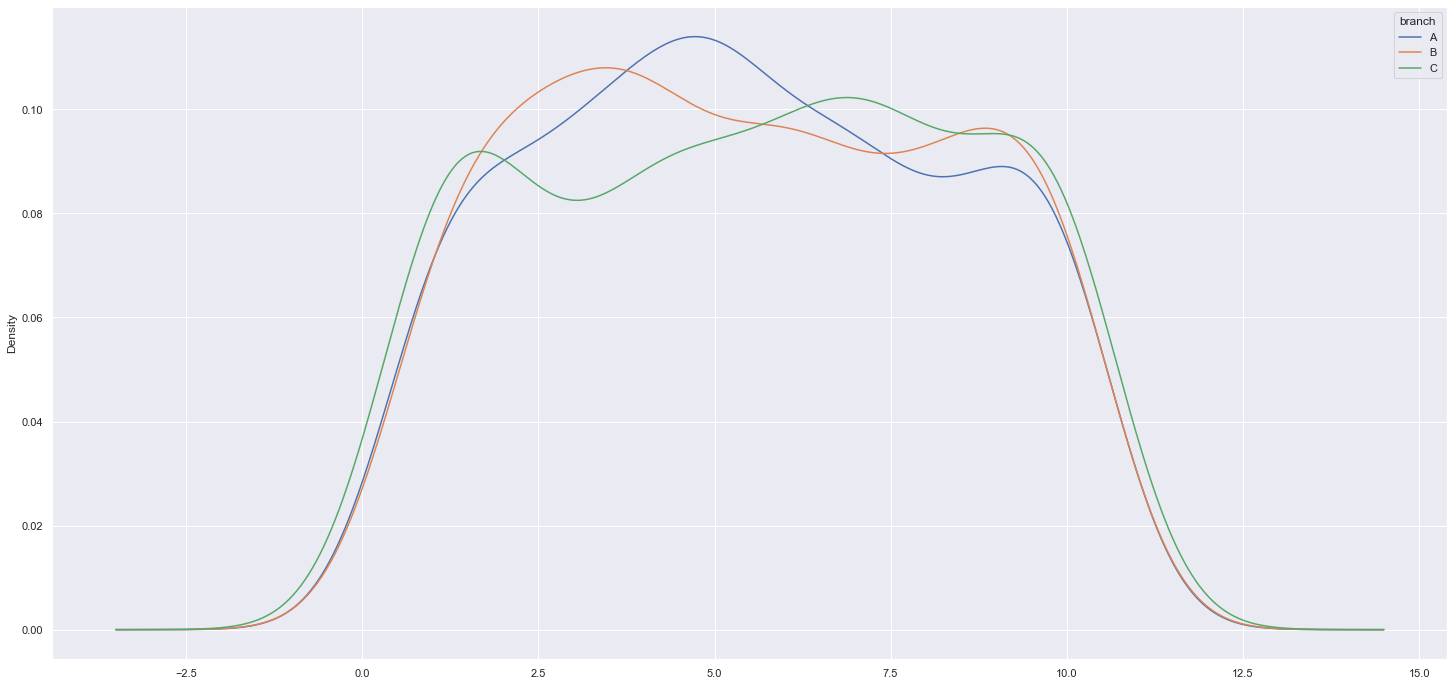

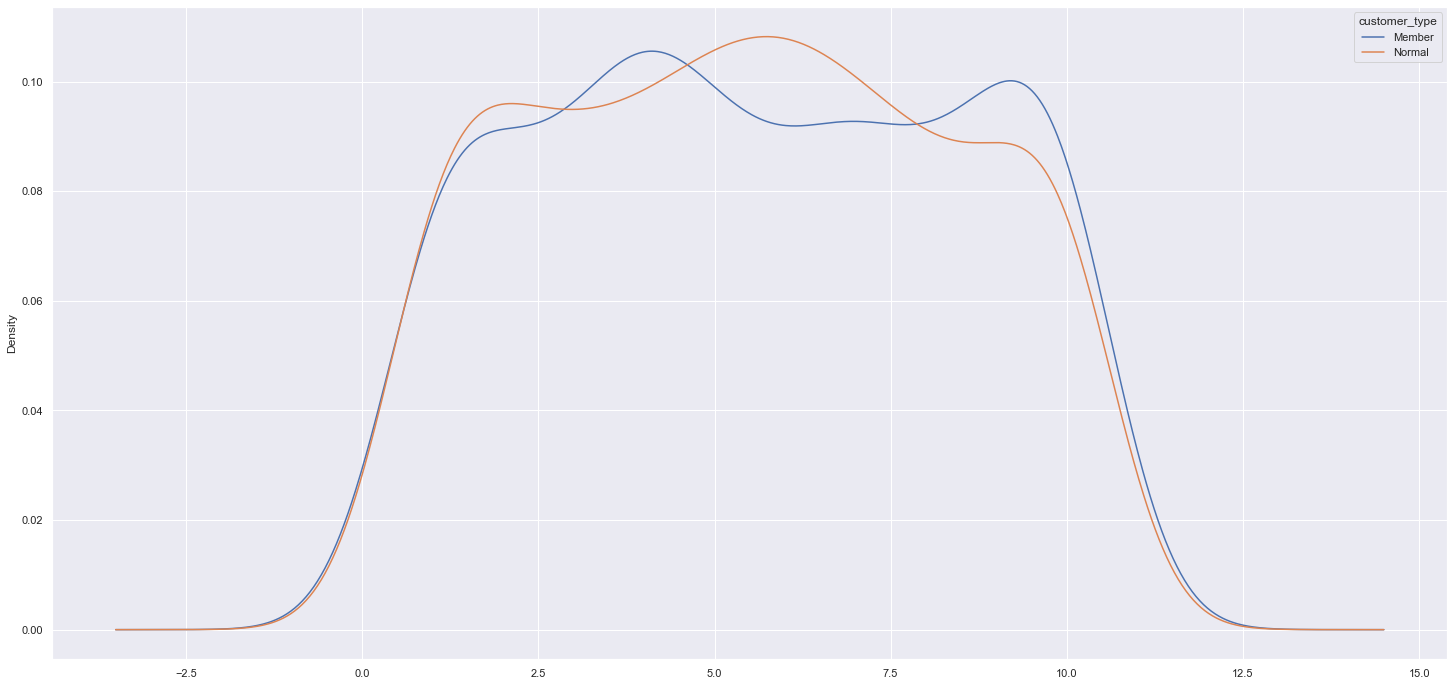

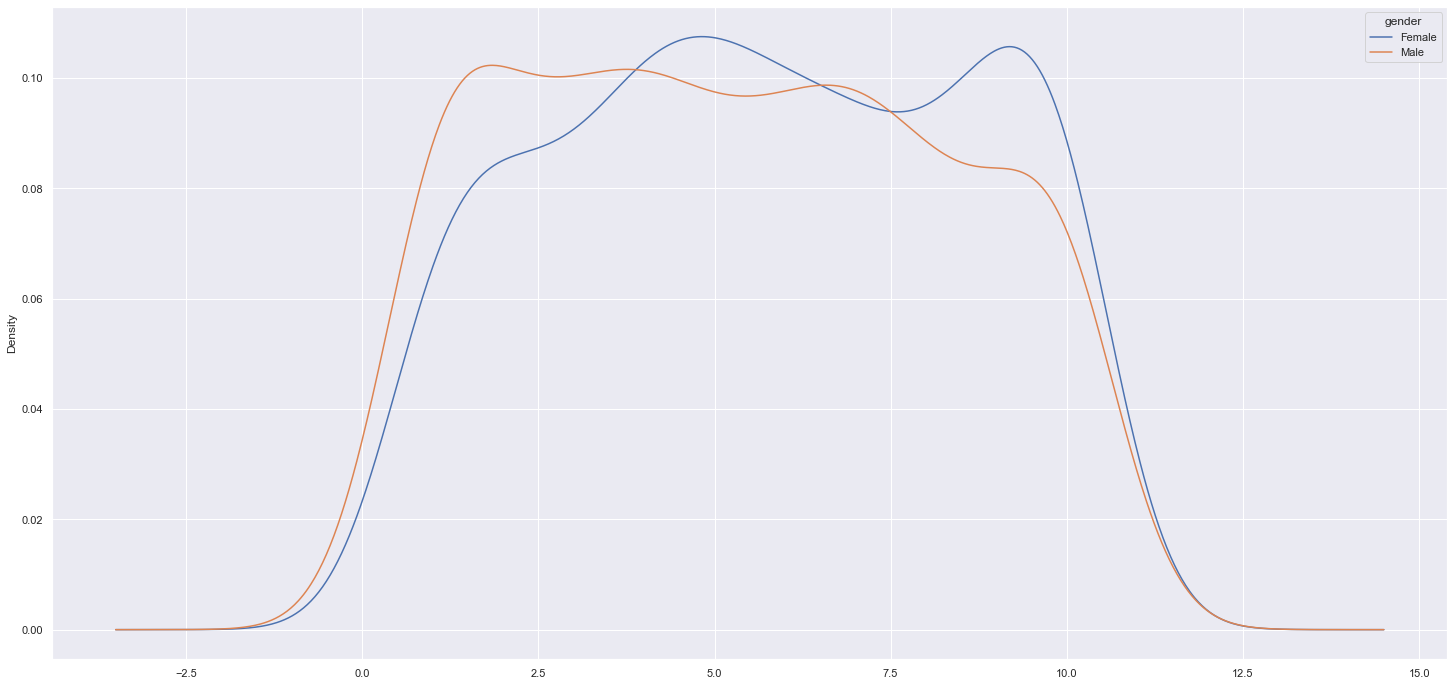

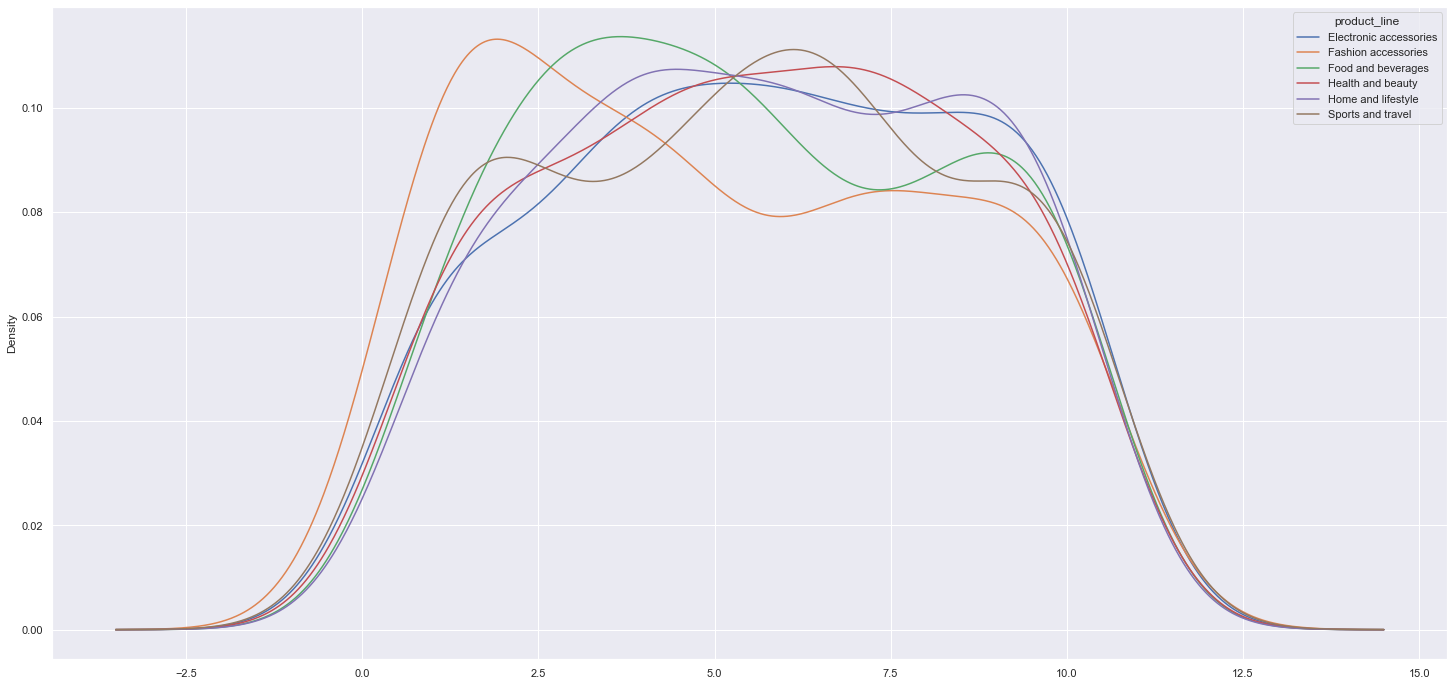

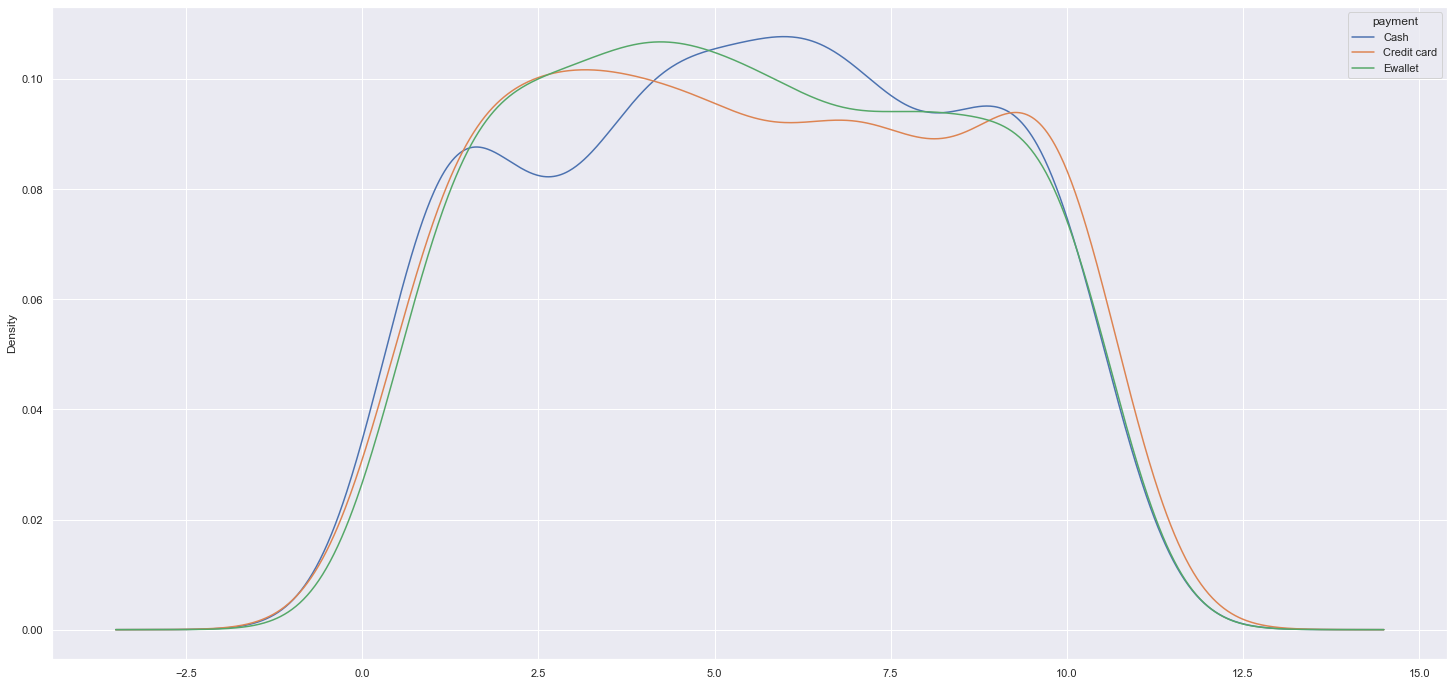

In [26]:
densityplot_quali_quanti(df2, 'quantity', 'branch')
densityplot_quali_quanti(df2, 'quantity', 'customer_type')
densityplot_quali_quanti(df2, 'quantity', 'gender')
densityplot_quali_quanti(df2, 'quantity', 'product_line')
densityplot_quali_quanti(df2, 'quantity', 'payment')

In [27]:
qb = r_quad(df2, 'quantity', 'branch')
qc = r_quad(df2, 'quantity', 'customer_type')
qg = r_quad(df2, 'quantity', 'gender')
qprod = r_quad(df2, 'quantity', 'product_line')
qpay = r_quad(df2, 'quantity', 'payment')

[qb, qc, qg, qprod, qpay]

[-0.0017043090531820848,
 -0.0007206315200949387,
 0.004517734382640248,
 0.0008001125605962001,
 -0.0019565101485521375]

o R-quadrado evidência que as variáveis quantitativas tem pouca influência para explicar a variação da variável quantity 

<AxesSubplot:ylabel='Density'>

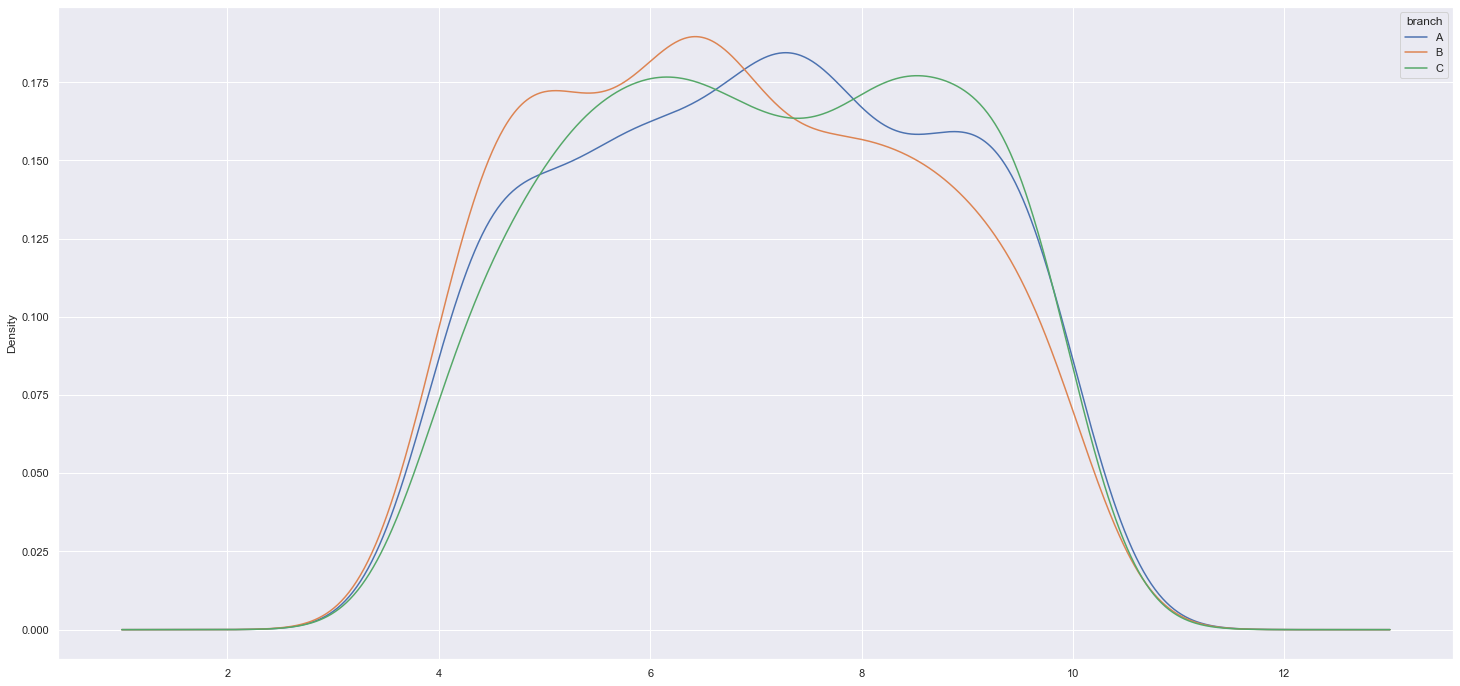

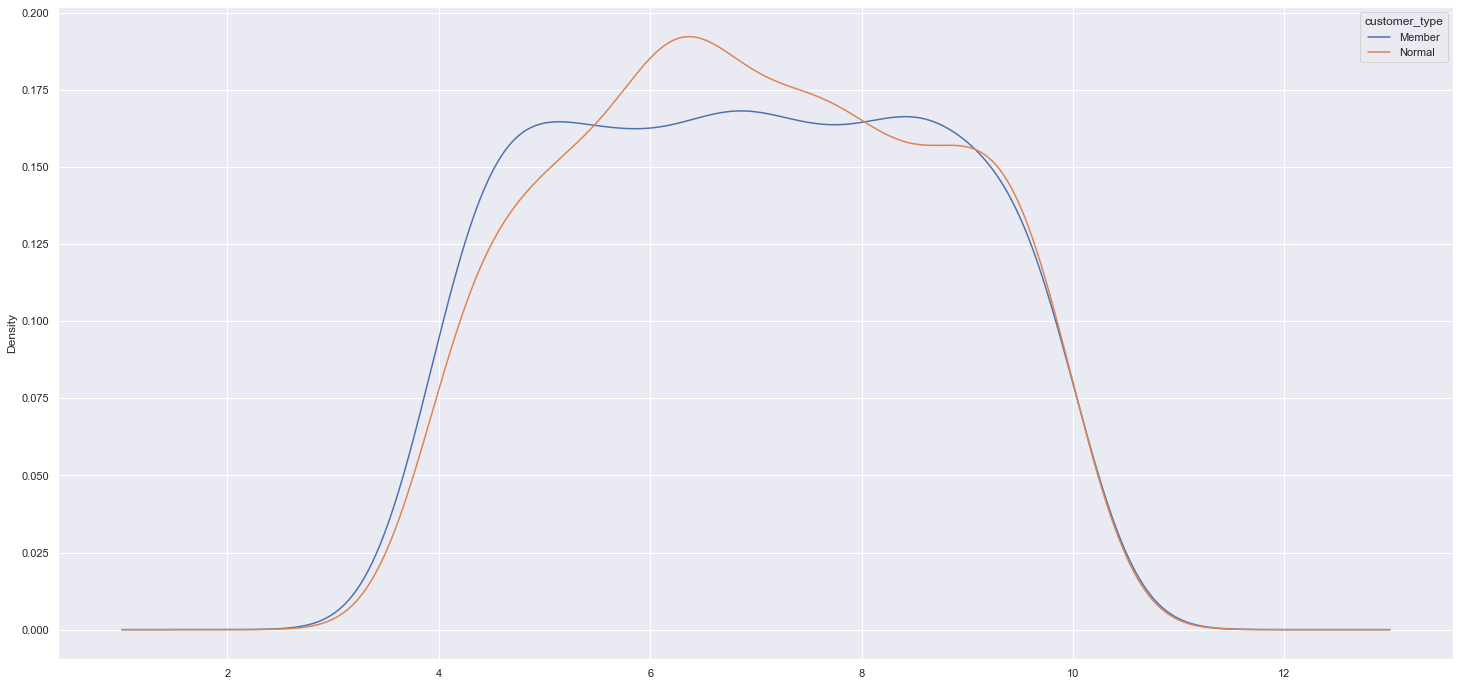

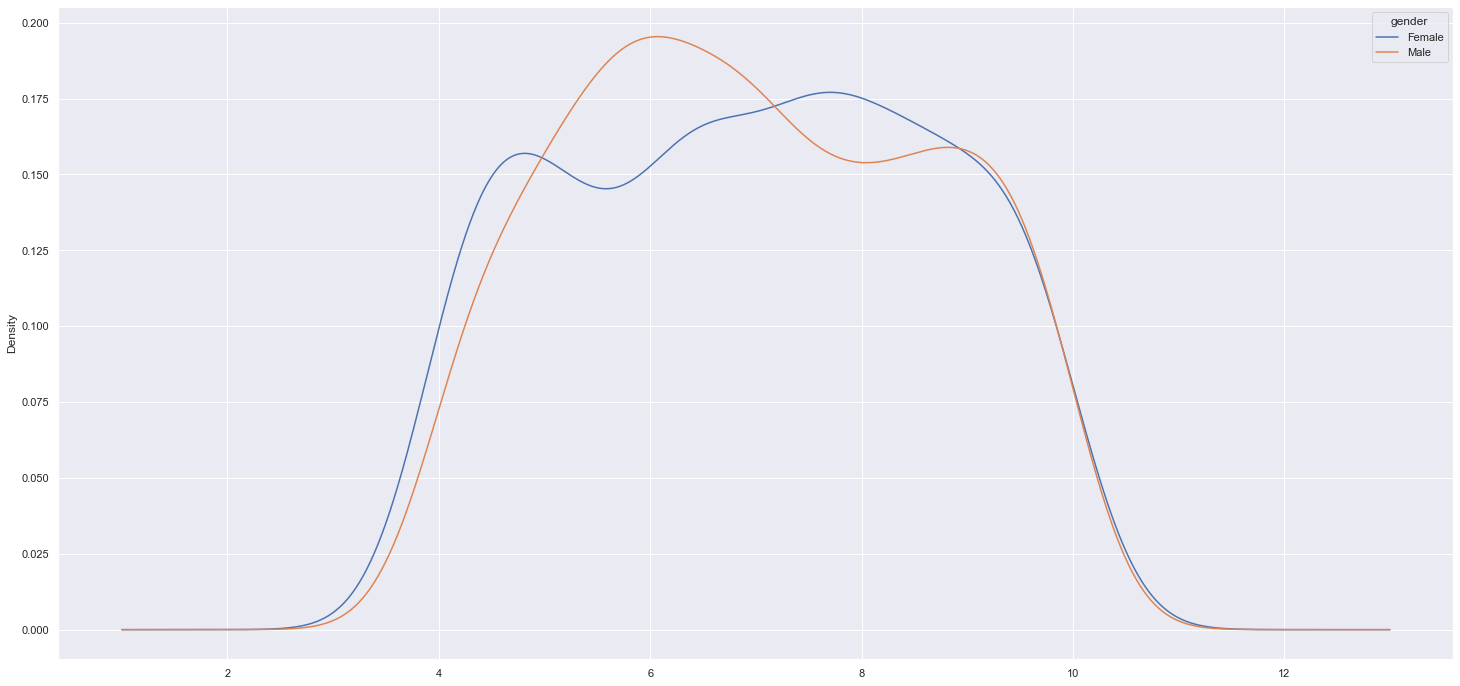

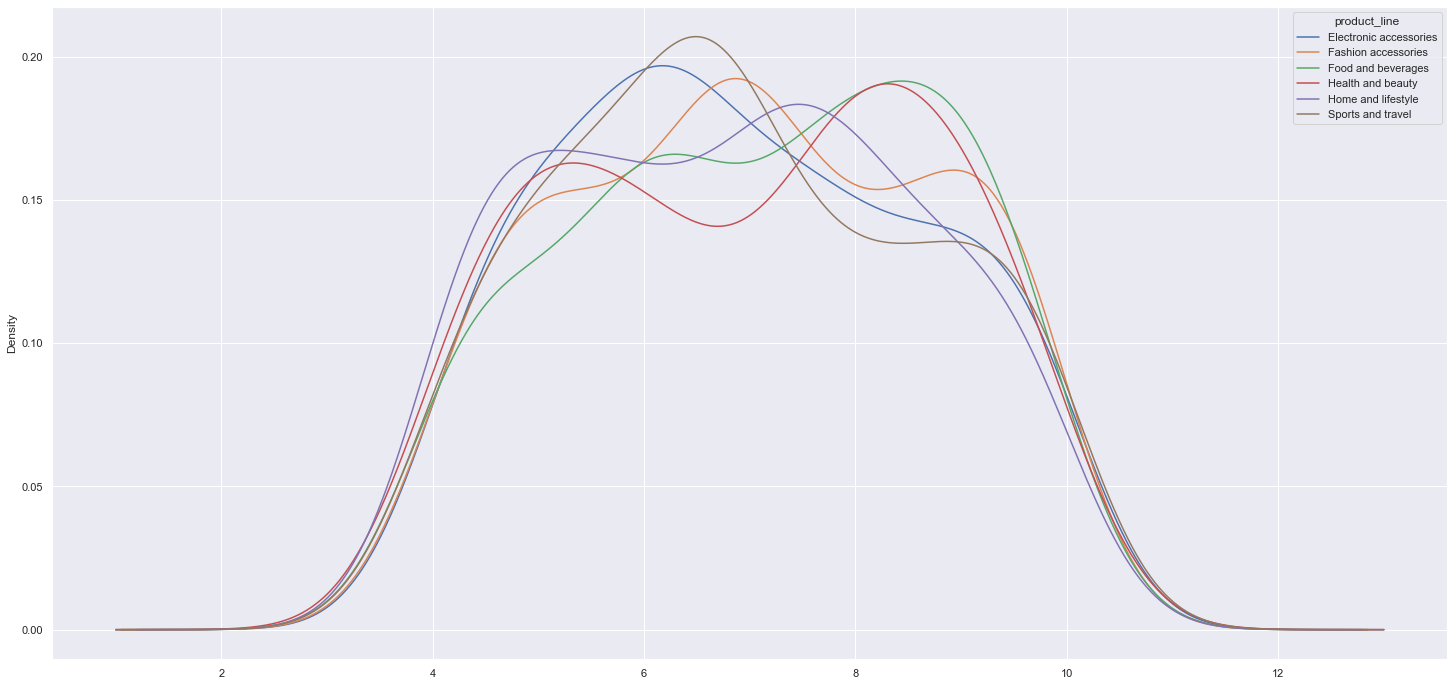

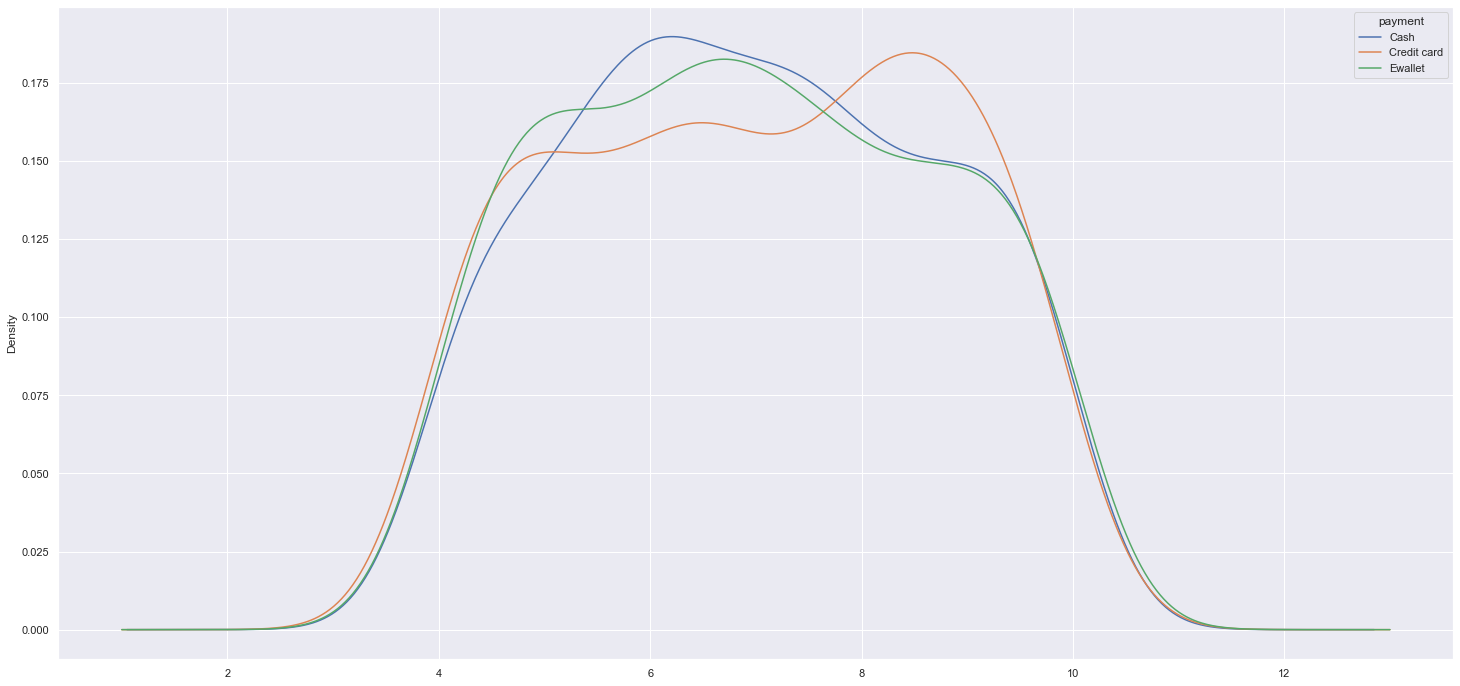

In [28]:
densityplot_quali_quanti(df2, 'rating', 'branch')
densityplot_quali_quanti(df2, 'rating', 'customer_type')
densityplot_quali_quanti(df2, 'rating', 'gender')
densityplot_quali_quanti(df2, 'rating', 'product_line')
densityplot_quali_quanti(df2, 'rating', 'payment')

<AxesSubplot:ylabel='Density'>

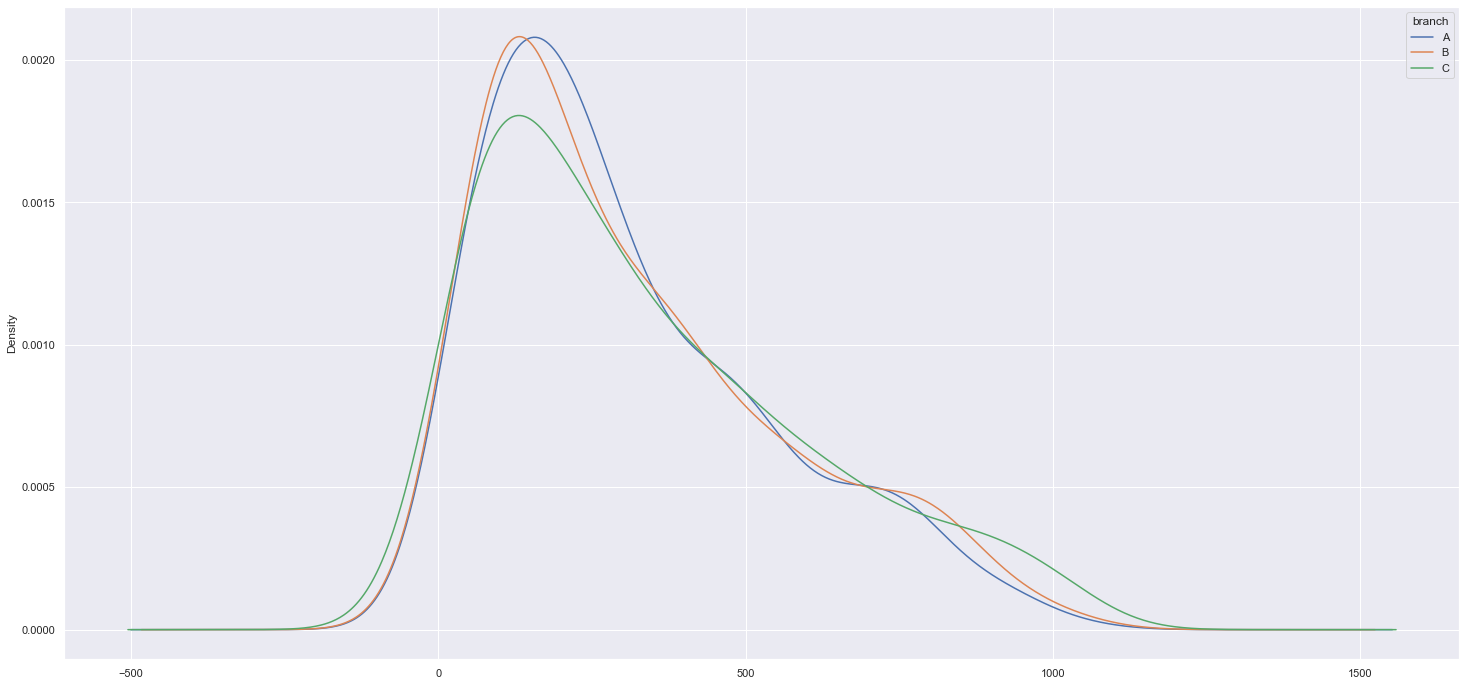

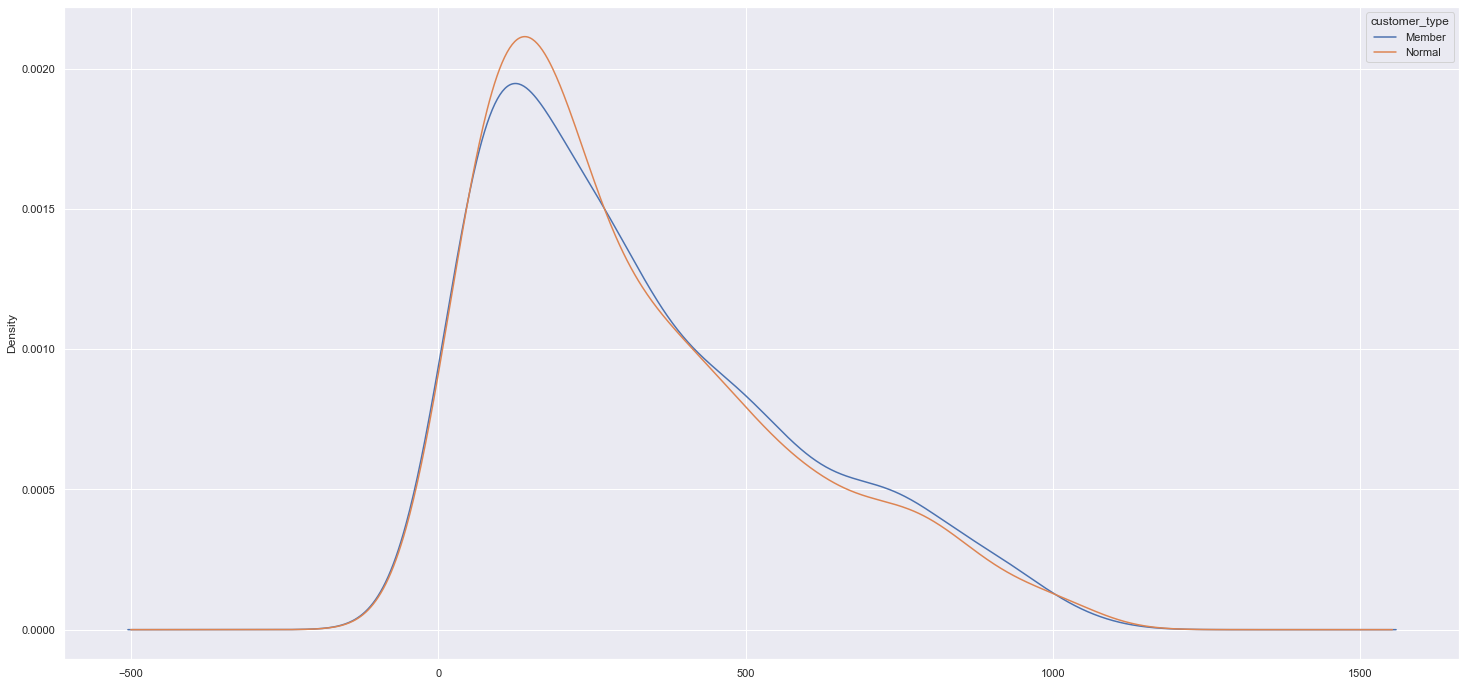

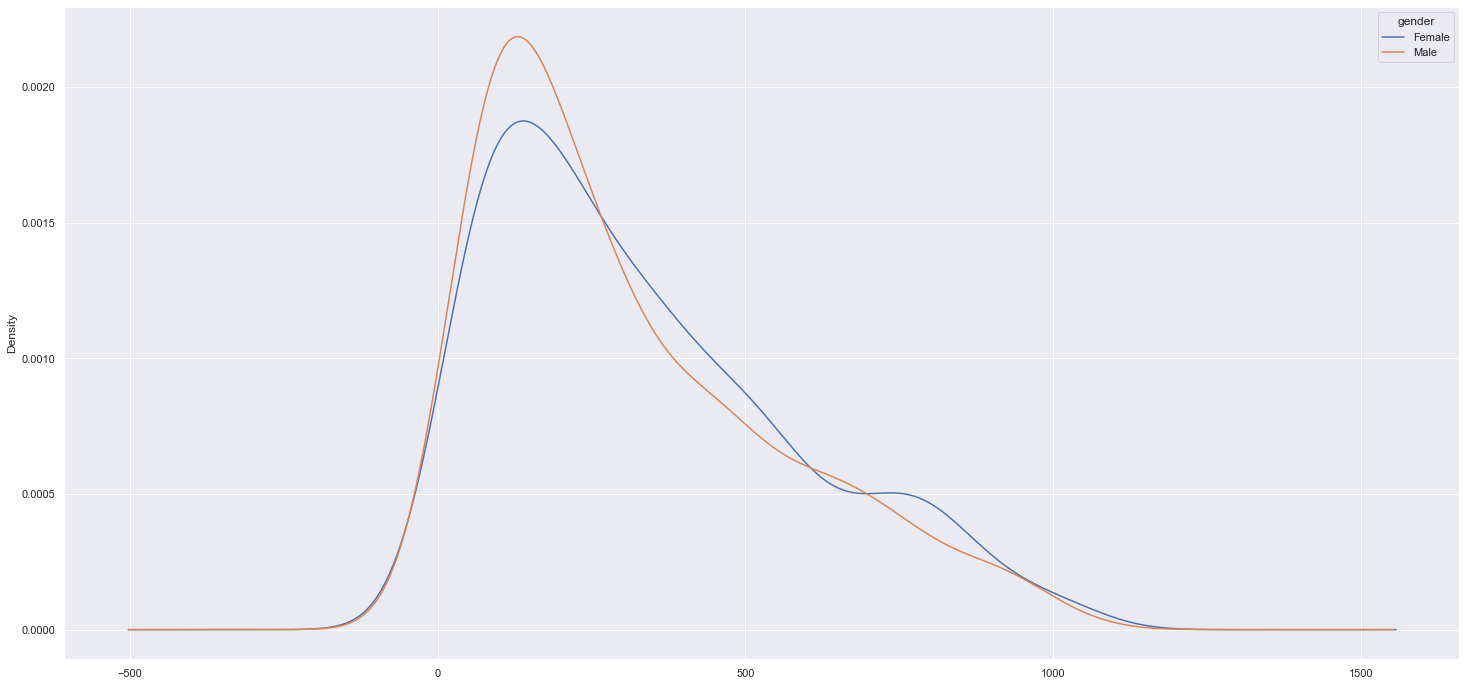

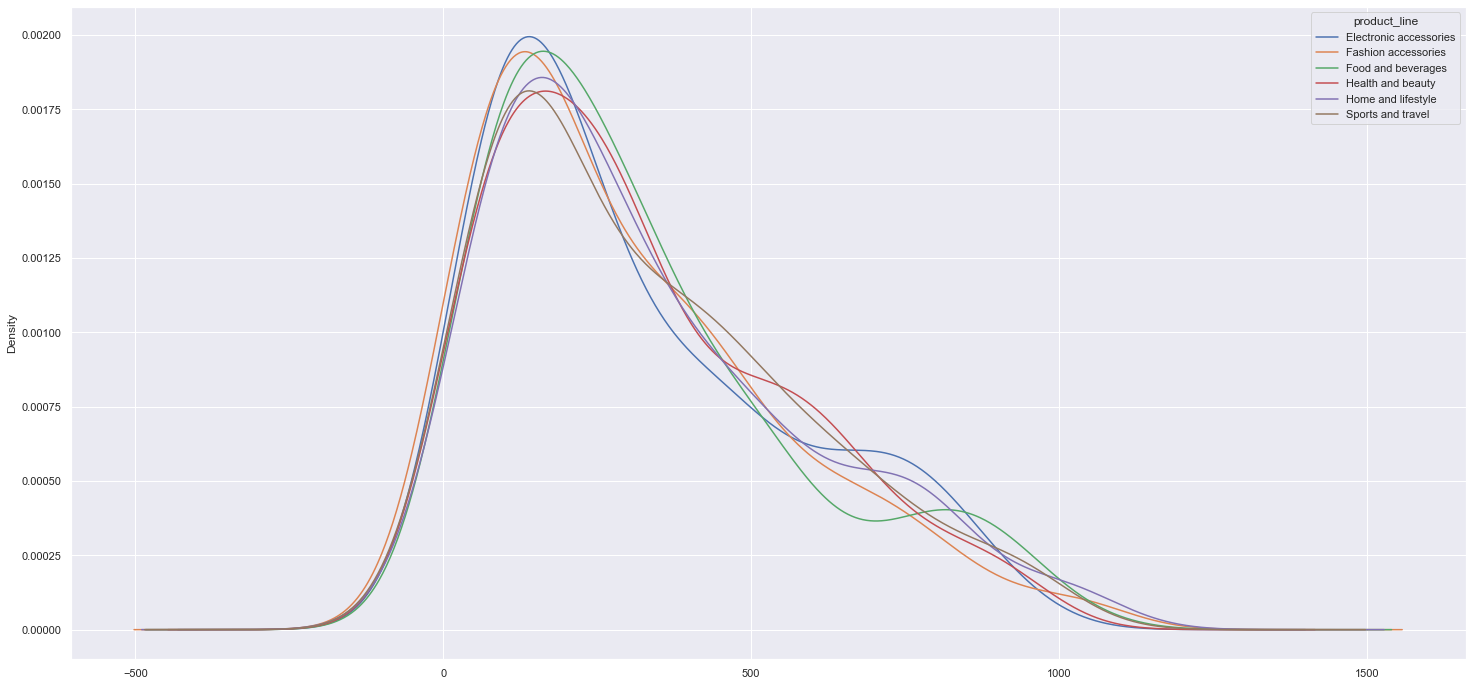

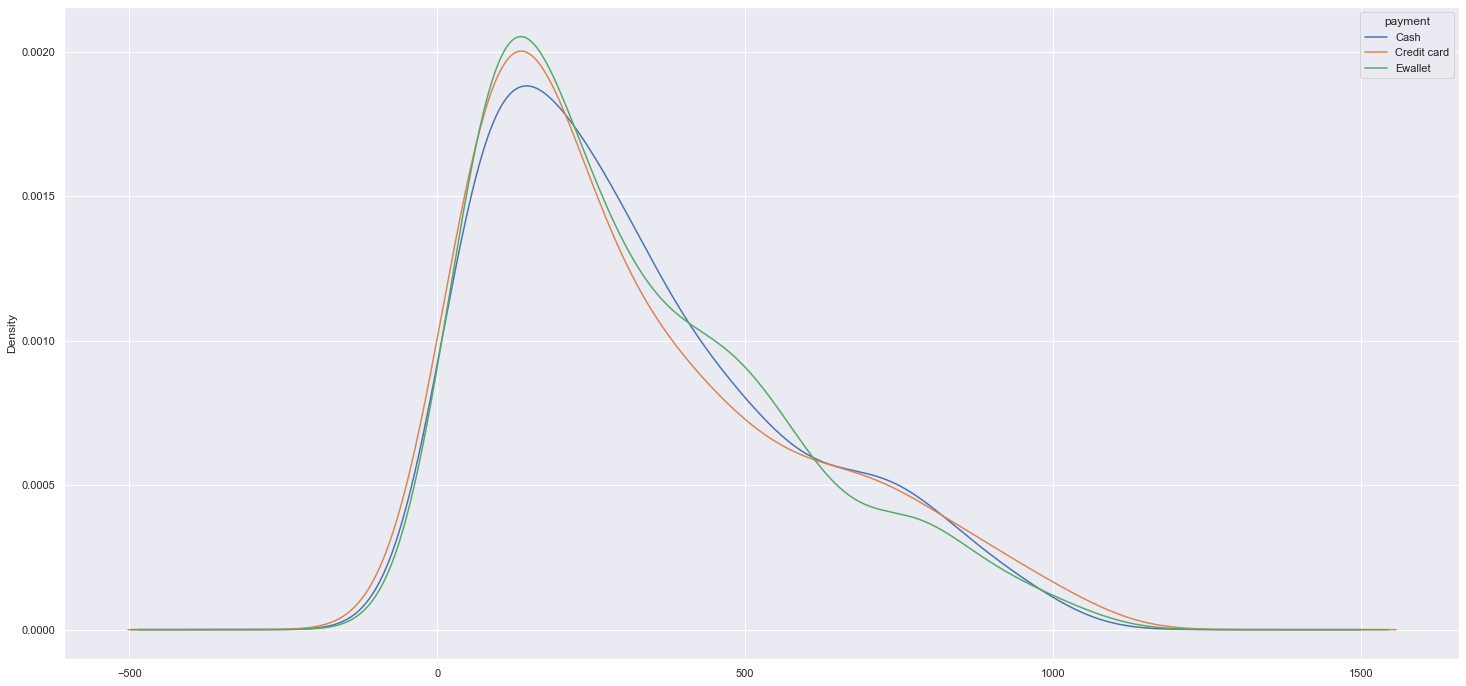

In [29]:
densityplot_quali_quanti(df2, 'total', 'branch')
densityplot_quali_quanti(df2, 'total', 'customer_type')
densityplot_quali_quanti(df2, 'total', 'gender')
densityplot_quali_quanti(df2, 'total', 'product_line')
densityplot_quali_quanti(df2, 'total', 'payment')

<AxesSubplot:xlabel='product_line', ylabel='unit_price'>

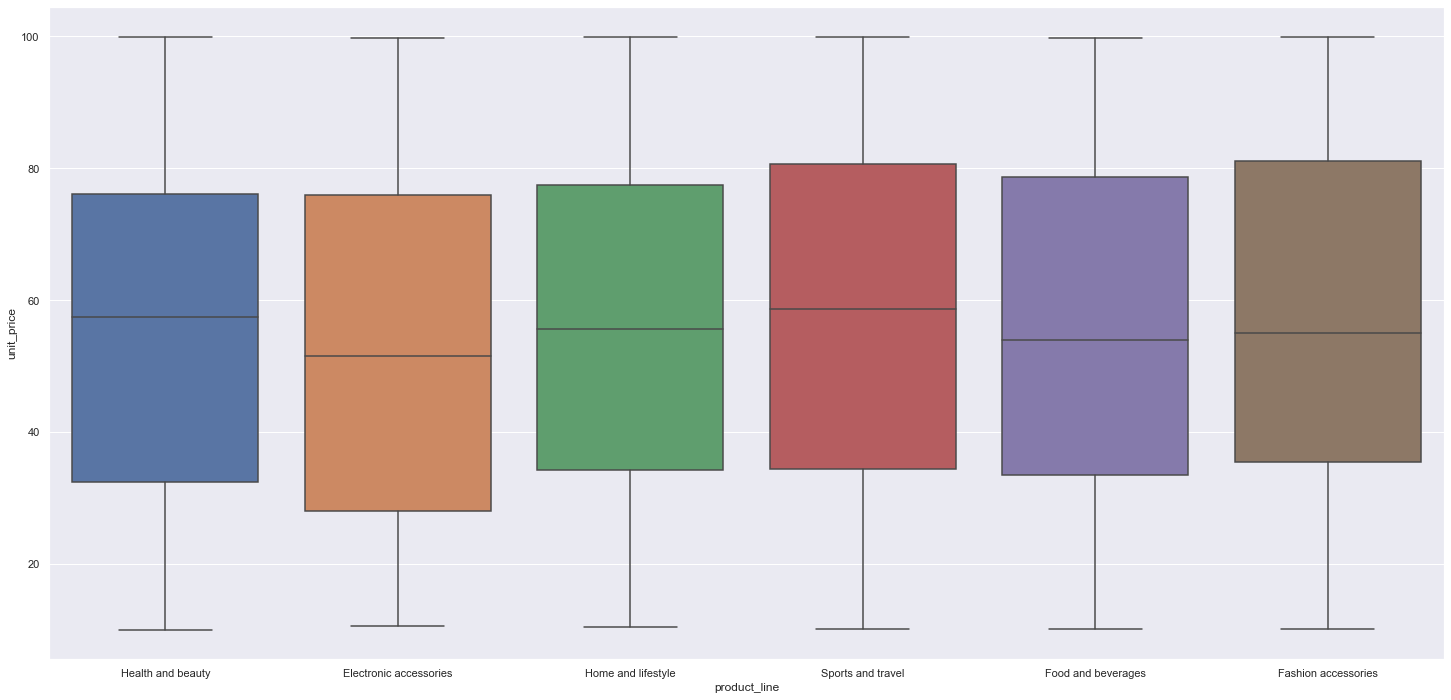

In [30]:
sns.boxplot( x = "product_line", y = "unit_price", data = df2)

<b>Conclusões:</b> Avaliando as dispersões das variaveis quantitativas e das variaveis qualitativas aparetemente a variação das variáveis quantitativas não está relacionada as categorias das variáveis quantitativas

In [31]:
df2[['branch','quantity', 'total']].groupby('branch').sum().reset_index()

,branch,quantity,total
0,A,1859,106200.3705
1,B,1820,106197.6720
2,C,1831,110568.7065


As vendas por canal estão muito semelhantes, tanto em quantidade, quanto em dinheiro.

#### 2.3.2.2. Variáveis qualitativas vs Variáveis qualitativas

In [32]:
tab_cont(df2, "branch", "city")

city,Mandalay,Naypyidaw,Yangon,Mandalay_perc,Naypyidaw_perc,Yangon_perc
branch,,,,,,
A,NaN,NaN,340.0,NaN,NaN,0.34
B,332.0,NaN,NaN,0.332,NaN,NaN
C,NaN,328.0,NaN,NaN,0.328,NaN


In [33]:
tab_cont(df2, "branch", "customer_type")

customer_type,Member,Normal,Member_perc,Normal_perc
branch,,,,
A,167,173,0.167,0.173
B,165,167,0.165,0.167
C,169,159,0.169,0.159


<AxesSubplot:xlabel='branch', ylabel='count'>

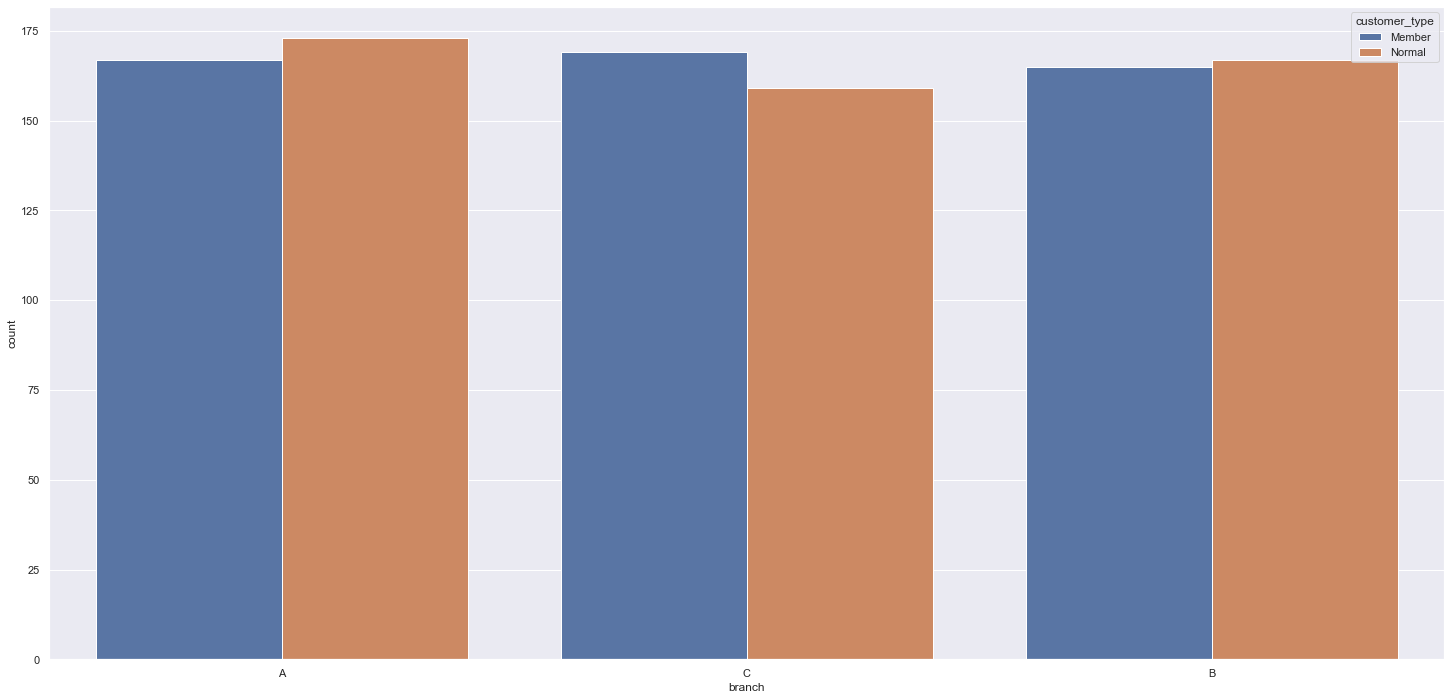

In [34]:
sns.countplot(x = 'branch', data = df2, hue = 'customer_type')

In [35]:
tab_cont(df2, "branch", "gender")

gender,Female,Male,Female_perc,Male_perc
branch,,,,
A,161,179,0.161,0.179
B,162,170,0.162,0.170
C,178,150,0.178,0.150


<AxesSubplot:xlabel='branch', ylabel='count'>

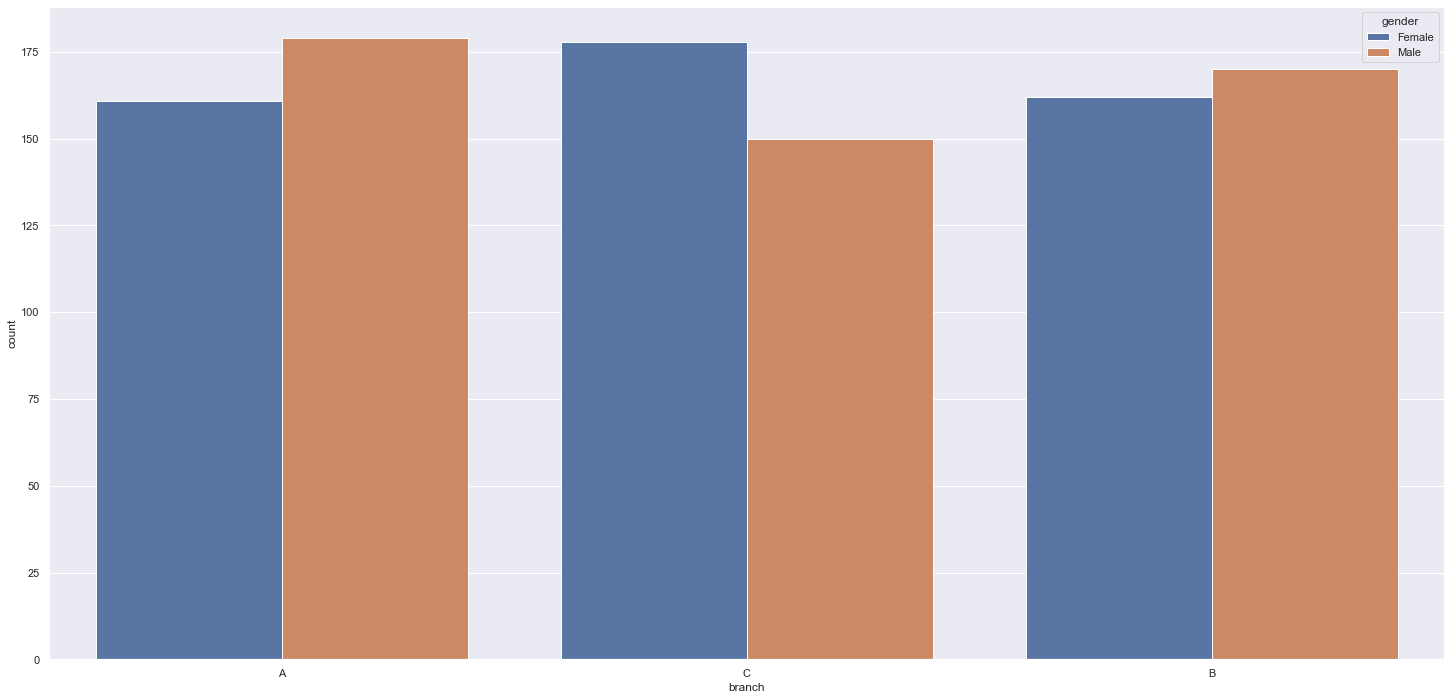

In [36]:
sns.countplot(x = 'branch', data = df2, hue = 'gender')

In [37]:
tab_cont(df2, "branch", "product_line")

product_line,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel,Electronic accessories_perc,Fashion accessories_perc,Food and beverages_perc,Health and beauty_perc,Home and lifestyle_perc,Sports and travel_perc
branch,,,,,,,,,,,,
A,60,51,58,47,65,59,0.060,0.051,0.058,0.047,0.065,0.059
B,55,62,50,53,50,62,0.055,0.062,0.050,0.053,0.050,0.062
C,55,65,66,52,45,45,0.055,0.065,0.066,0.052,0.045,0.045


<AxesSubplot:xlabel='branch', ylabel='count'>

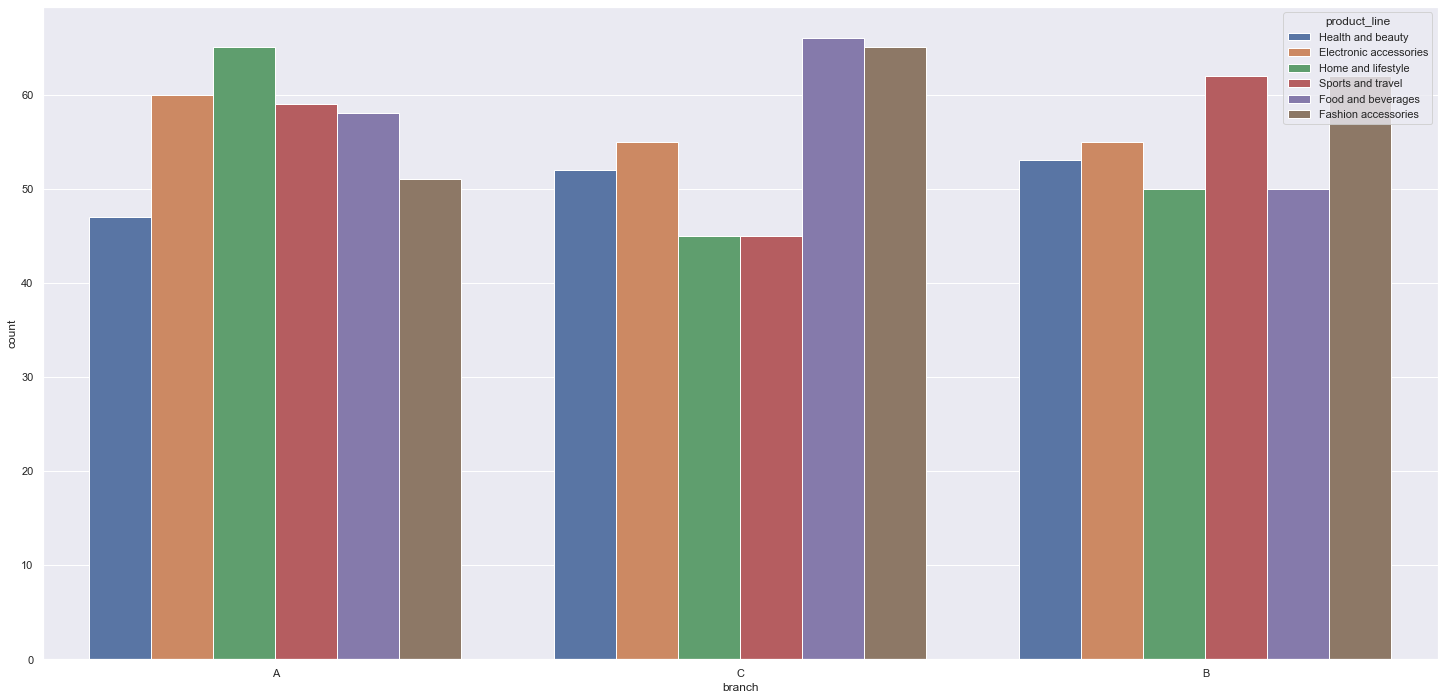

In [38]:
sns.countplot(x = 'branch', data = df2, hue = 'product_line')

In [39]:
tab_cont(df2, "branch", "payment")

payment,Cash,Credit card,Ewallet,Cash_perc,Credit card_perc,Ewallet_perc
branch,,,,,,
A,110,104,126,0.110,0.104,0.126
B,110,109,113,0.110,0.109,0.113
C,124,98,106,0.124,0.098,0.106


<AxesSubplot:xlabel='branch', ylabel='count'>

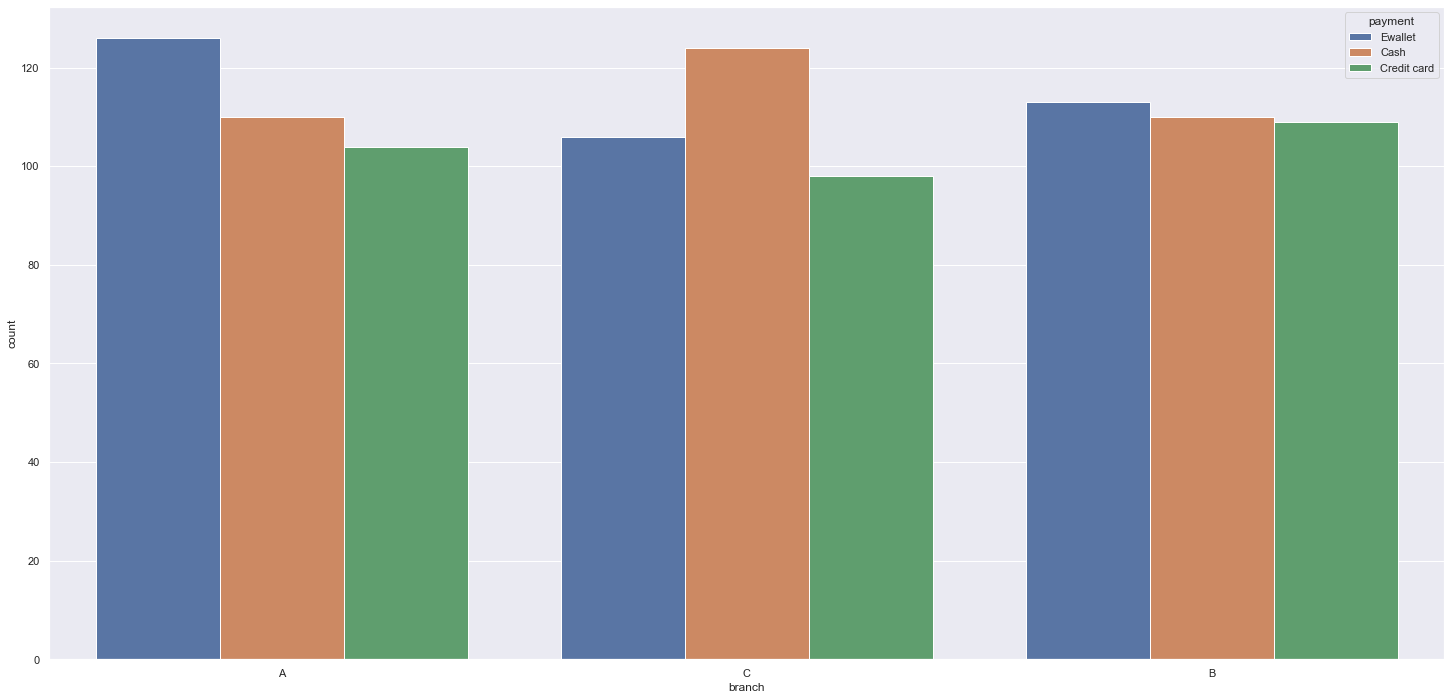

In [40]:
sns.countplot(x = 'branch', data = df2, hue = 'payment')

<AxesSubplot:xlabel='customer_type', ylabel='count'>

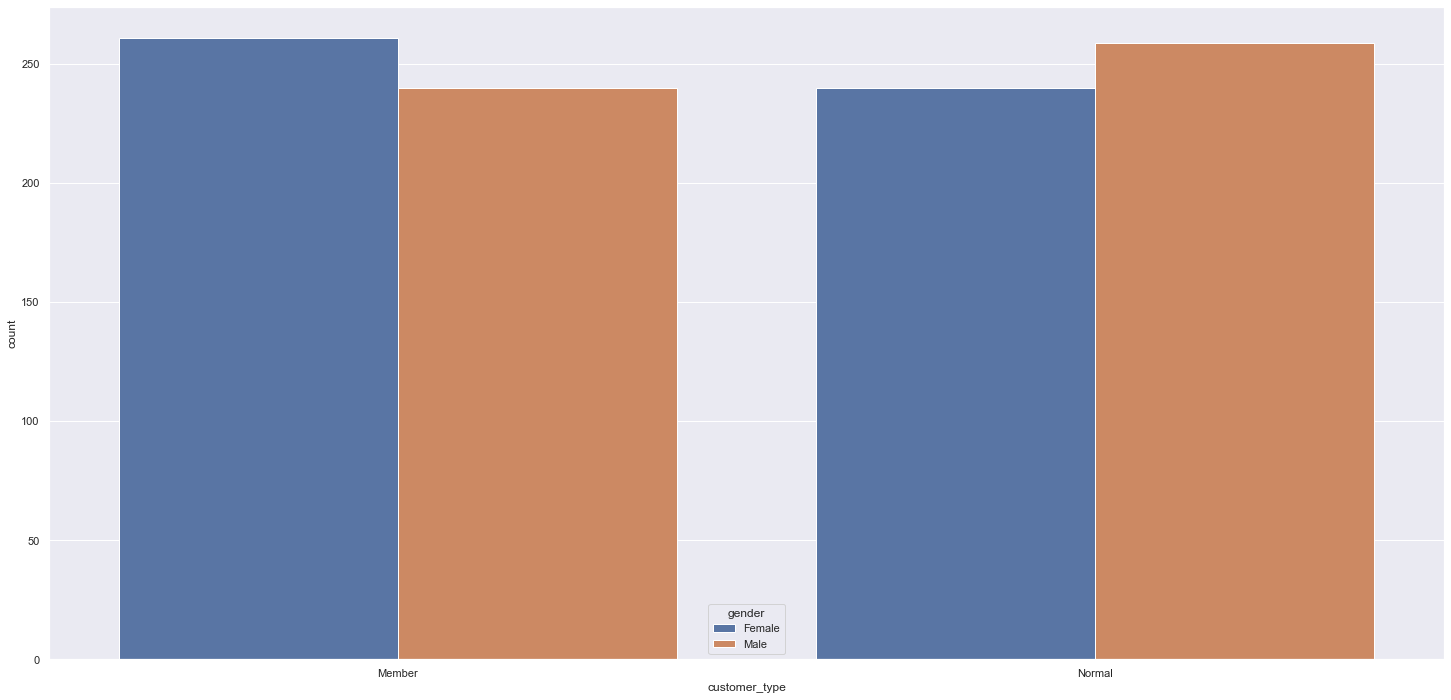

In [41]:
sns.countplot(x = 'customer_type', data = df2, hue = 'gender')

<AxesSubplot:xlabel='customer_type', ylabel='count'>

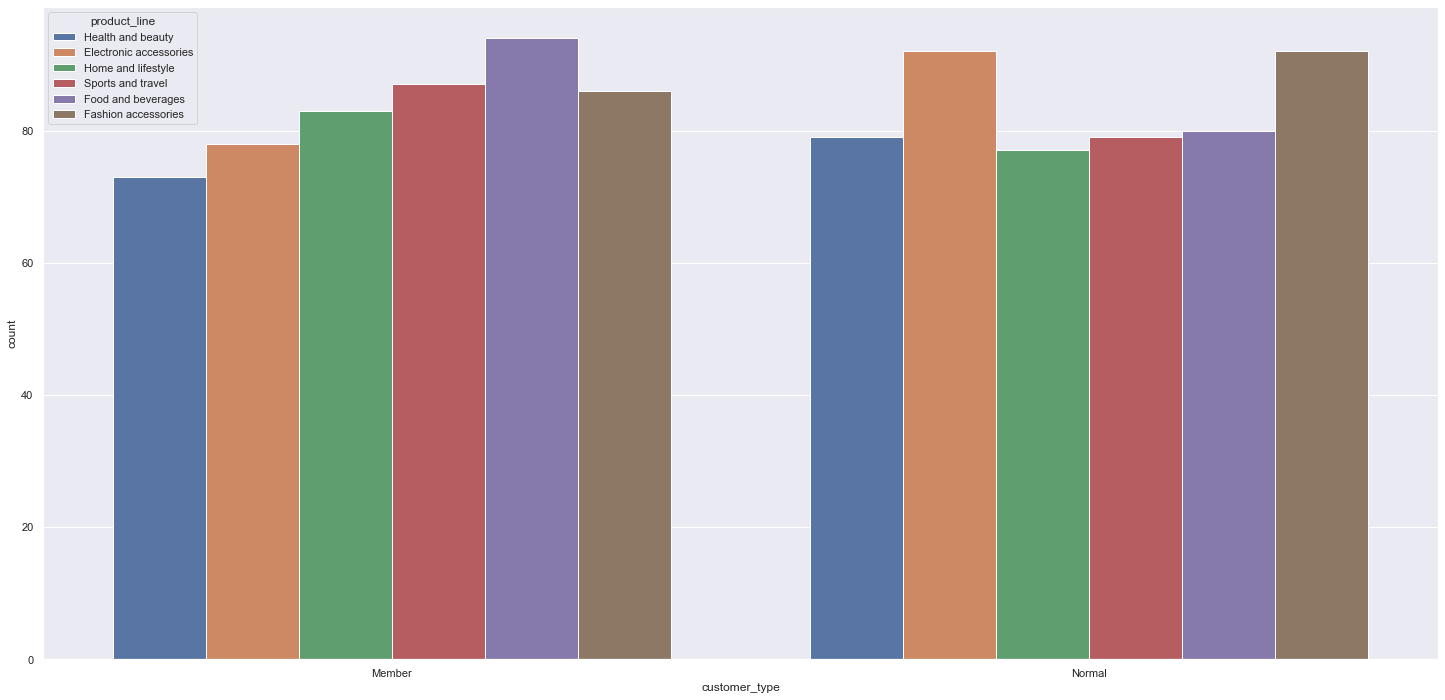

In [42]:
sns.countplot(x = 'customer_type', data = df2, hue = 'product_line')

<AxesSubplot:xlabel='customer_type', ylabel='count'>

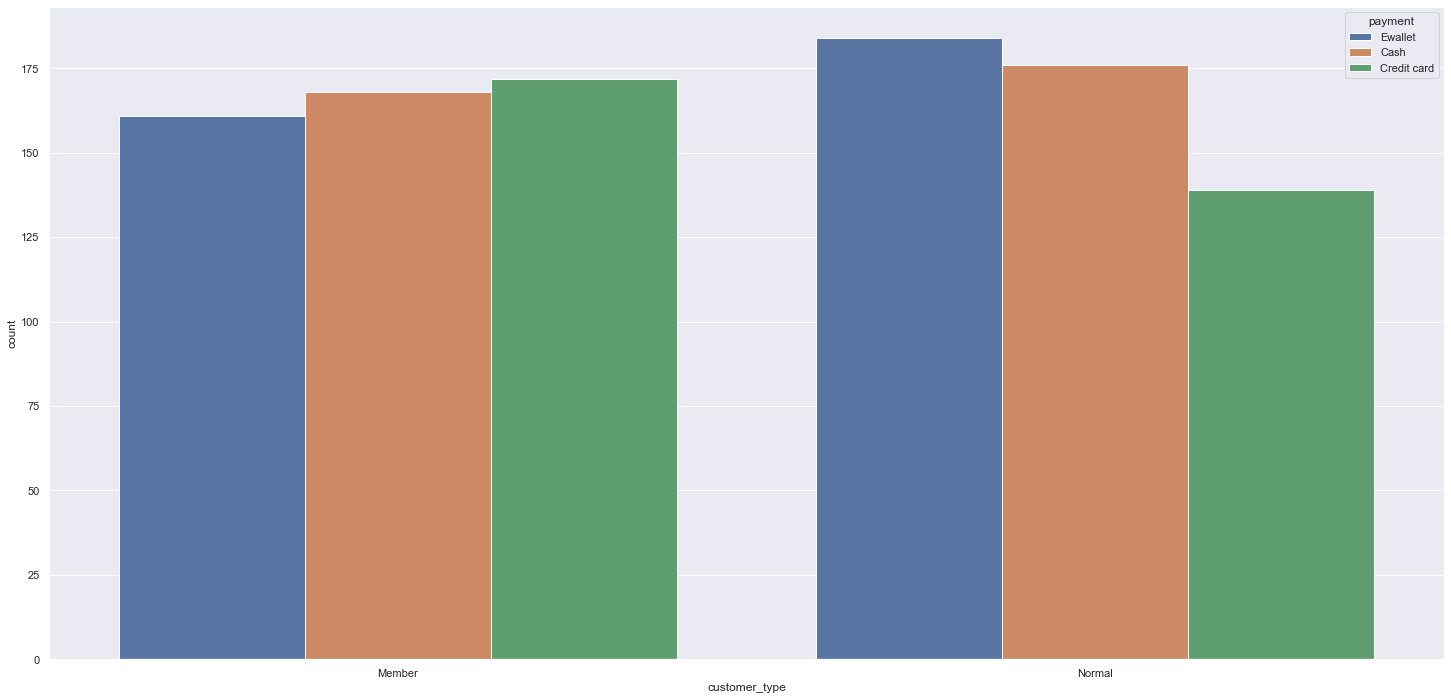

In [43]:
sns.countplot(x = 'customer_type', data = df2, hue = 'payment')

<AxesSubplot:xlabel='gender', ylabel='count'>

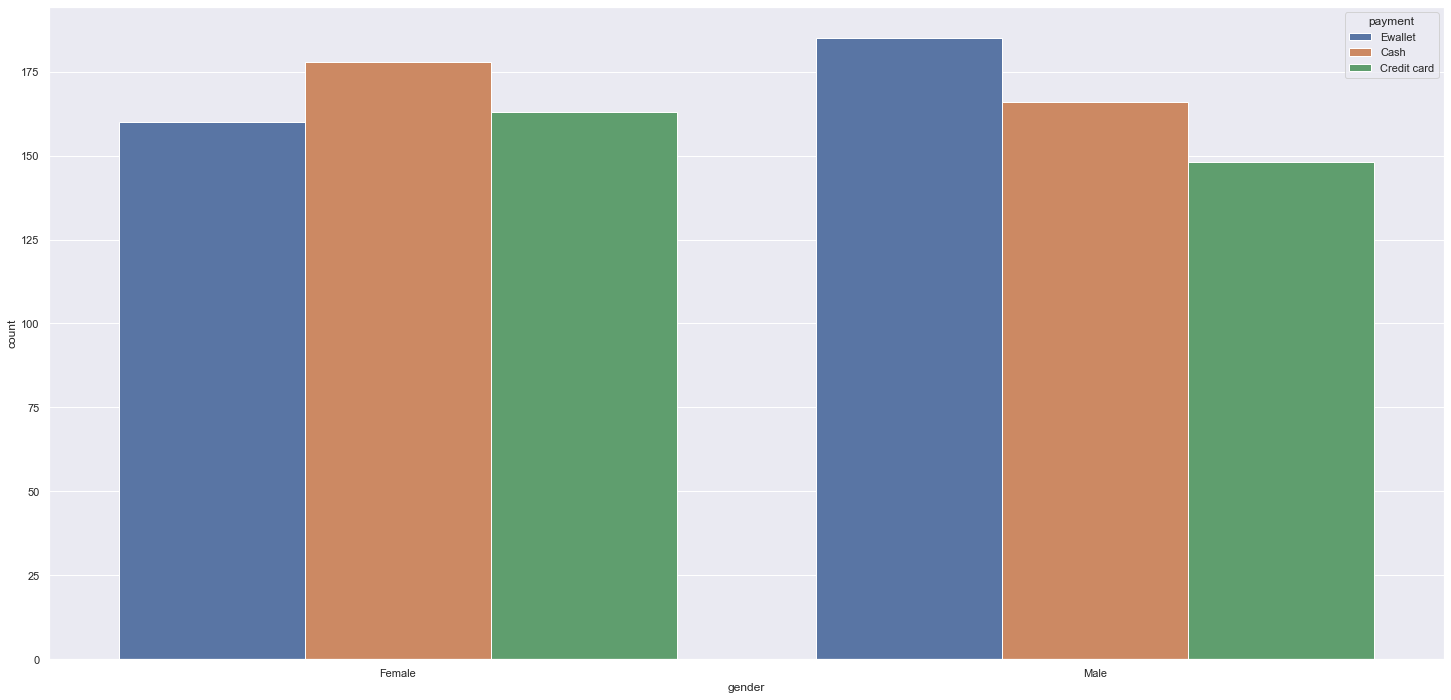

In [44]:
sns.countplot(x = 'gender', data = df2, hue = 'payment')

<AxesSubplot:xlabel='gender', ylabel='count'>

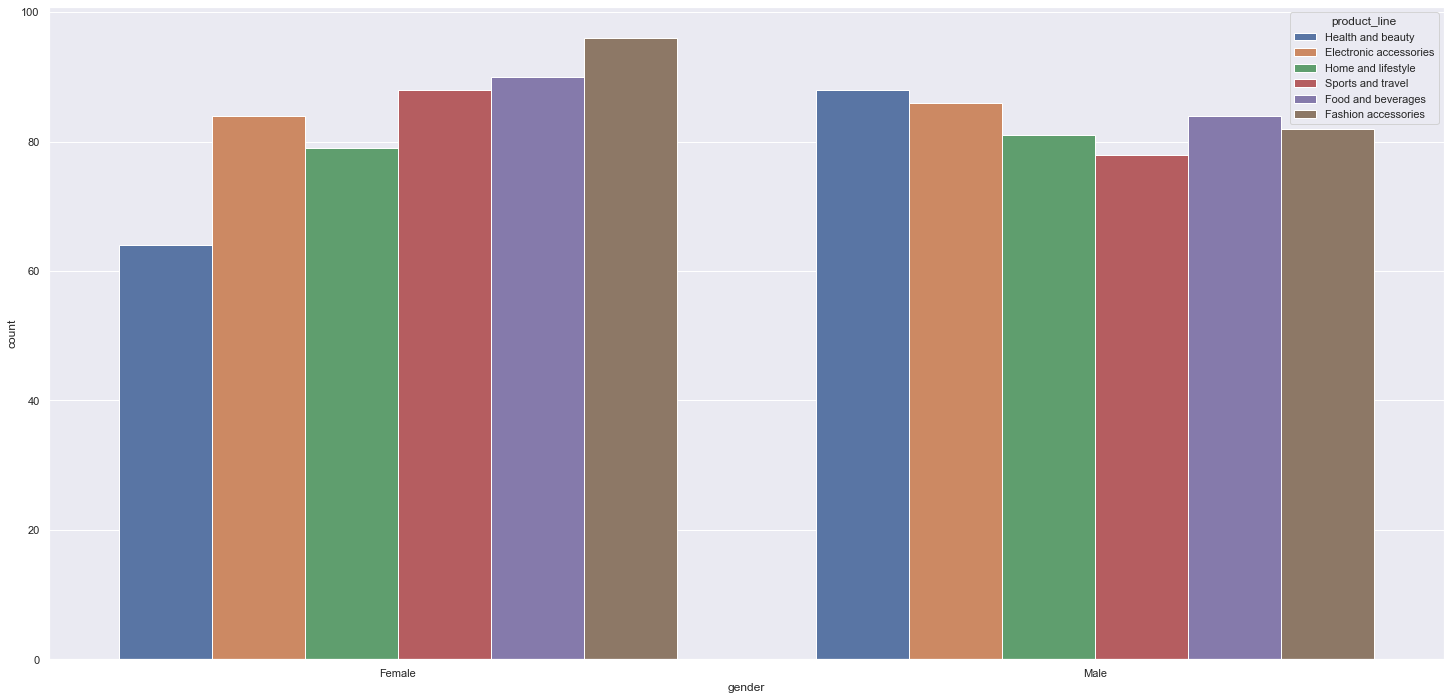

In [45]:
sns.countplot(x = 'gender', data = df2, hue = 'product_line')

<AxesSubplot:xlabel='product_line', ylabel='count'>

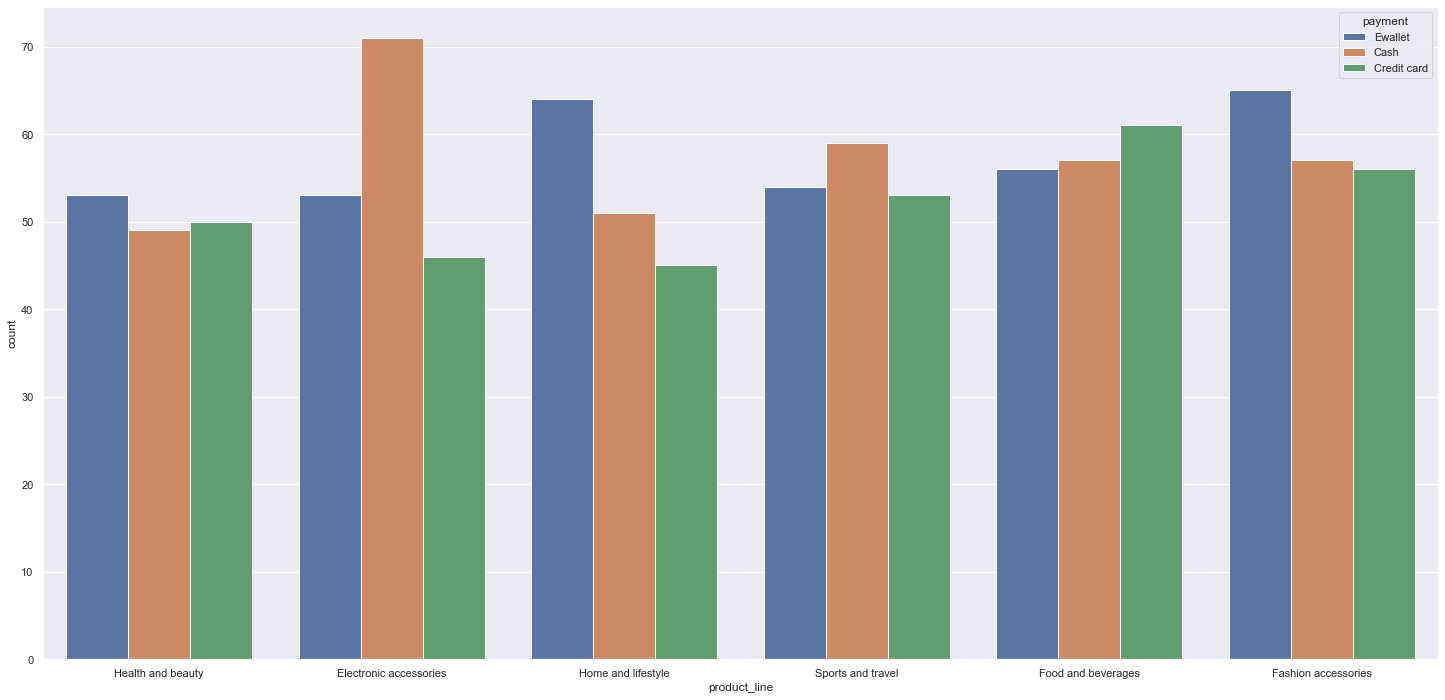

In [46]:
sns.countplot(x = 'product_line', data = df2, hue = 'payment')

<b>Conclusões:</b> Avaliando a frequência de transações para as variaveis categoricas percebemos que existem algumas diferenças nos perfis de compra. Por exemplo, na branch C a maior parte das transações foi feita por mulheres, mas na A a maior parte foi feita por homens. 

#### 2.3.2.2. Análise temporal

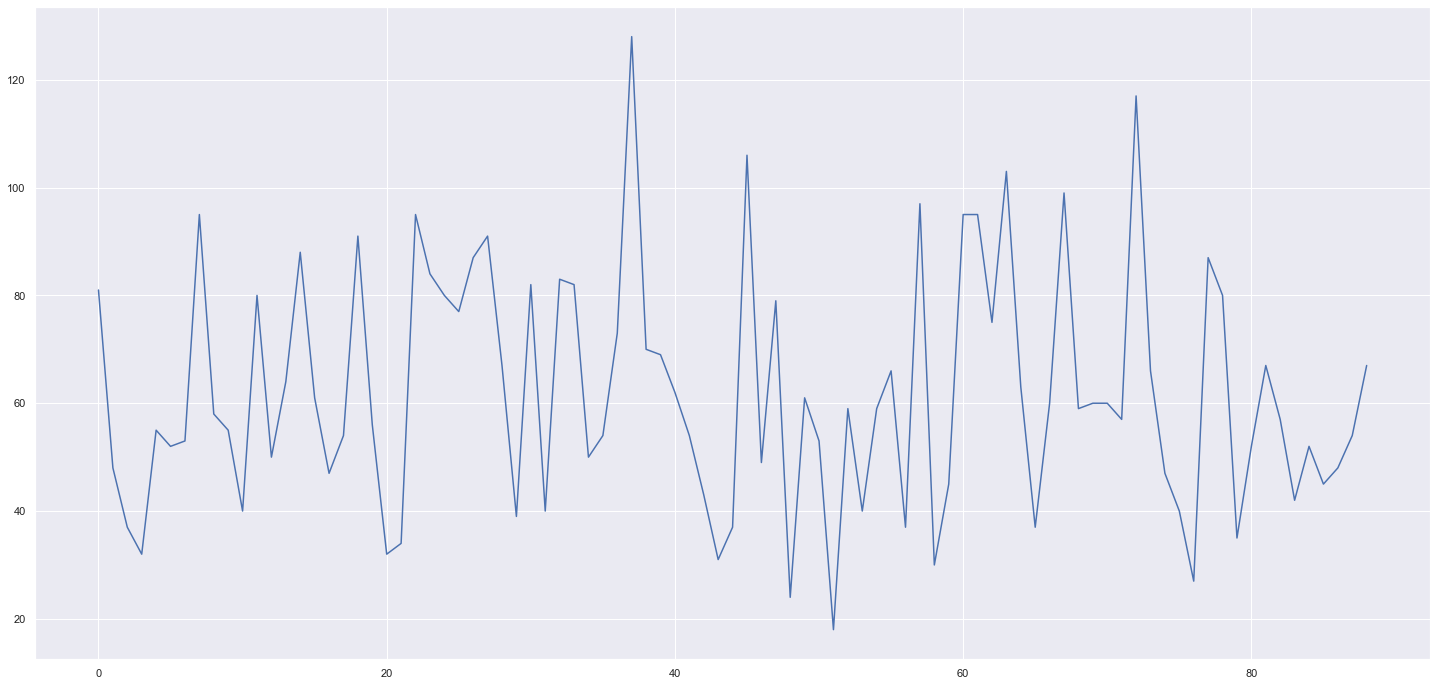

In [47]:
aux = df2
aux['day_of_year'] = aux['date_time'].dt.dayofyear
aux = aux[['day_of_year','quantity']].groupby('day_of_year').sum().reset_index()
plt.plot( aux['quantity'])

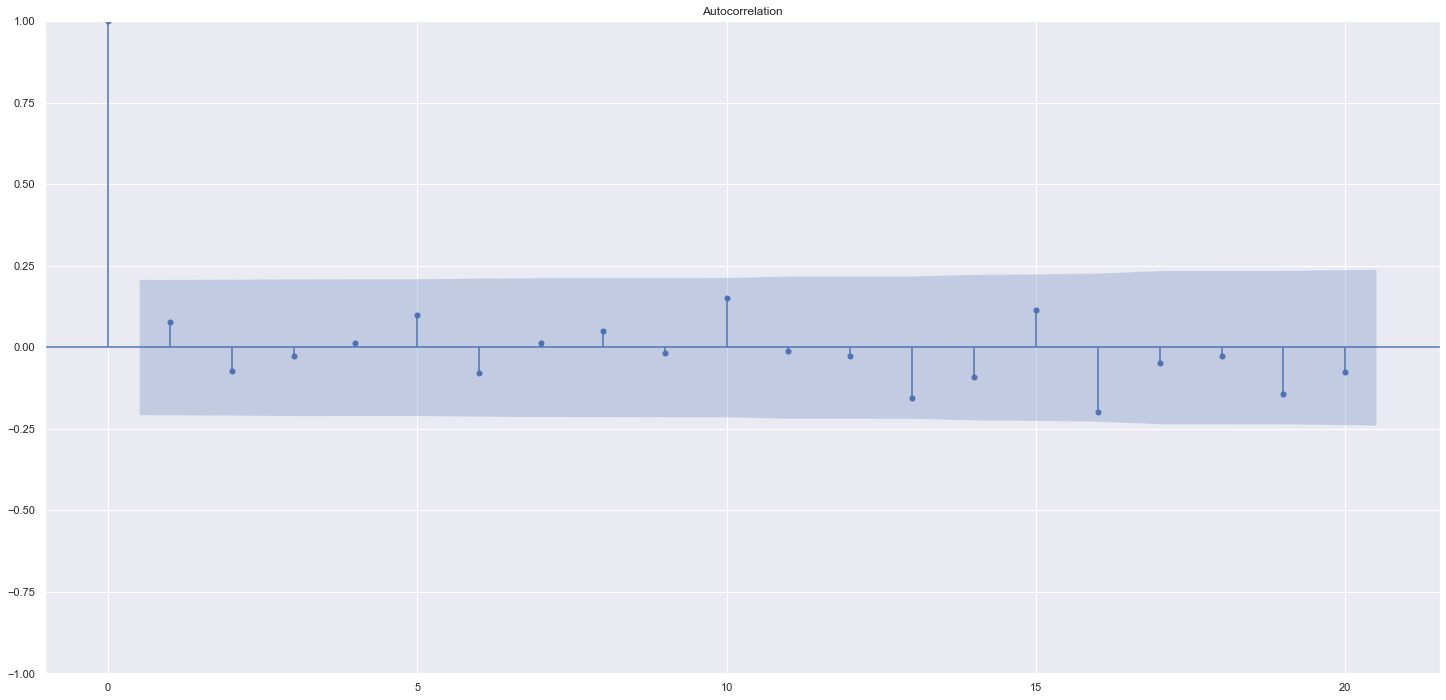

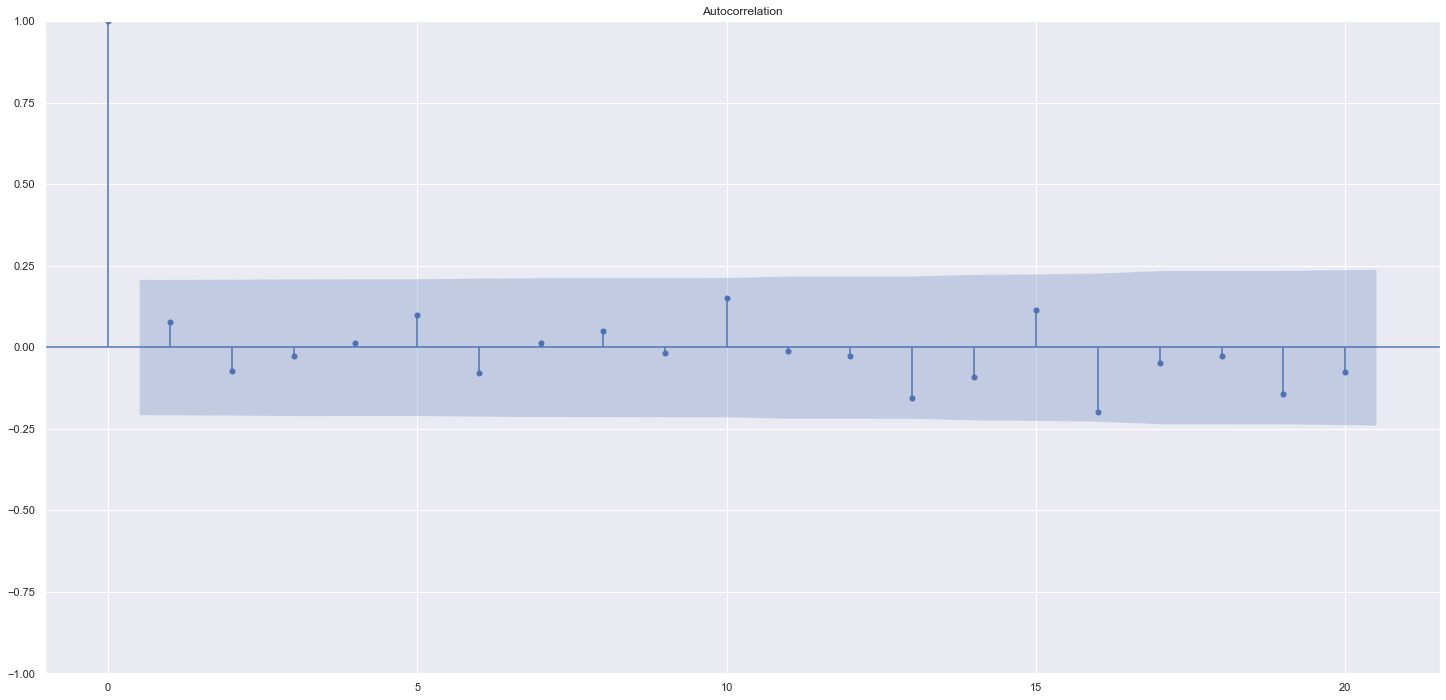

In [48]:
plt_acf( aux[['quantity']])

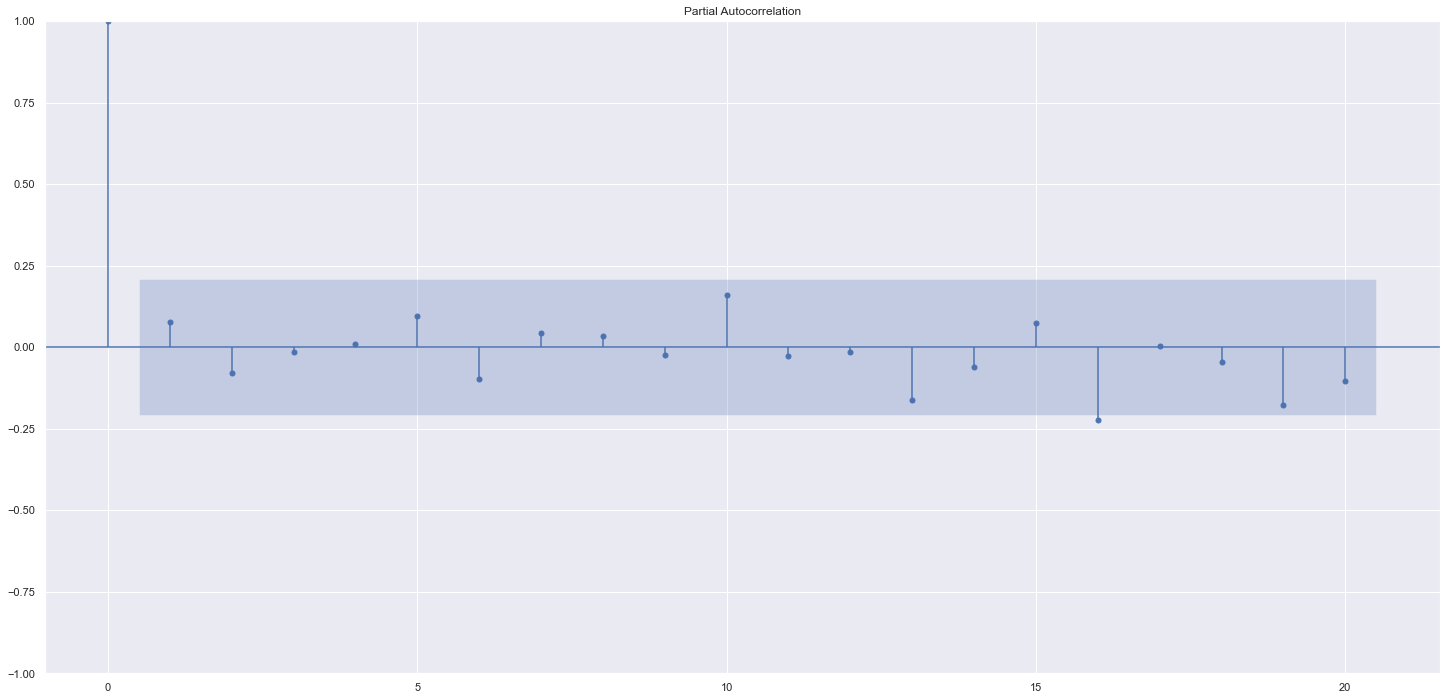

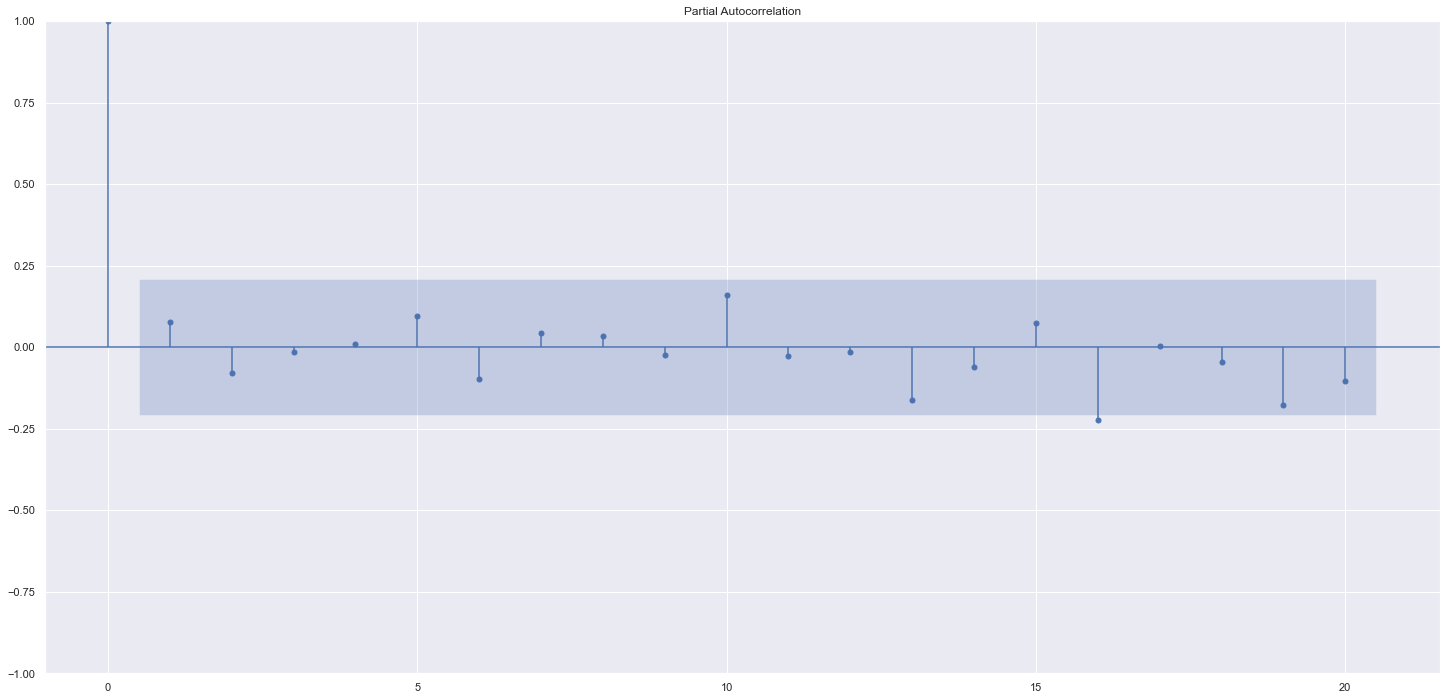

In [49]:
plot_pacf( aux['quantity'] , method = 'ywm')

Aparetemente o fator temporal não é relevante

# 3. Preparação dos dados

In [50]:
df3 = df2[['invoice_id','date_time','city', 'customer_type', 'gender', 'product_line', 'quantity', 'total', 'rating', 'payment']]

In [51]:
df3.sample(10)

,invoice_id,date_time,city,customer_type,gender,product_line,quantity,total,rating,payment
337,692-27-8933,2019-02-24 13:02:00,Mandalay,Normal,Female,Sports and travel,6,365.0850,5.2,Cash
320,649-11-3678,2019-02-26 20:26:00,Naypyidaw,Normal,Female,Food and beverages,9,216.6885,5.5,Cash
453,568-88-3448,2019-03-03 15:09:00,Yangon,Normal,Male,Health and beauty,1,26.2500,5.5,Ewallet
861,840-76-5966,2019-01-08 18:06:00,Yangon,Member,Male,Sports and travel,2,26.7960,7.8,Ewallet
154,400-89-4171,2019-01-28 13:05:00,Naypyidaw,Normal,Female,Sports and travel,8,680.1480,9.3,Cash
201,542-41-0513,2019-03-15 11:57:00,Mandalay,Member,Female,Electronic accessories,4,241.4580,6.6,Cash
700,626-43-7888,2019-02-07 12:23:00,Naypyidaw,Normal,Female,Fashion accessories,8,507.4440,9.6,Ewallet
750,210-30-7976,2019-03-14 11:16:00,Mandalay,Member,Female,Fashion accessories,4,93.7440,4.1,Ewallet
262,655-85-5130,2019-03-13 19:22:00,Mandalay,Member,Female,Fashion accessories,4,160.8600,5.7,Cash
341,433-75-6987,2019-03-05 19:06:00,Mandalay,Member,Female,Health and beauty,7,411.3795,8.9,Ewallet


Concluída a análise podemos agora criar uma classe que será responsável pela rotina de tratamento de dados

In [52]:
class supermarketSalesTreated( object ):
    def __init__ ( self ):
        self.funcao_classe = 'preparacao_dados_supermarket_sales'
        self.autor = 'Jefferson'
        
    def data_cleaning ( self, df2 ):
        
        cols_old = list(df2.columns)
        snakecase = lambda x: re.sub("%","_perc",re.sub(" ","_",inflection.underscore( x )))
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df2.columns = cols_new
        
        #change data types
        df2['date_time'] = df2['date'] + ' ' + df2['time']
        
        #df2['date'] = pd.to_datetime( df2['date'] , format = '%m/%d/%Y' ) 
        df2['date_time'] = pd.to_datetime( df2['date_time'] , format = '%m/%d/%Y %H:%M' ) 

        df2 = df2.drop('date',axis='columns')
        df2 = df2.drop('time',axis='columns')

        return df2
    
    def data_prep ( self, df2 ):
        df3 = df2[['invoice_id','date_time','city', 'customer_type', 'gender', 'product_line', 'quantity', 'total', 'rating', 'payment']]
        return df3
    
    def write_csv ( self, df3, path):
        df3.to_csv( path )
        
        


Neste caso, vamos usar a classe para escrever a base que já havíamos tratado e que será utilizada no PowerBI

In [53]:
supermarketSalesTreated().write_csv(df3, '../data/supermarket_sales_treated.csv')

# 4. Modelagem / Análise

Após a primeira análise exploratória dos dados percebemos que não existe fortes evidências de associação entre as variáveis. Poderíamos seguir com a análise realizando alguns testes de hipótese, mas como o foco principal ainda é o entedimento/ monitoramento dos indicadores do negócio a próxima etapa será a implantação de um dashboard em PowerBI. 

Neste sentido a prosposta inicial é avaliar os seguintes indicadores:
   * Vendas: quantidade vendida
   * Vendas: faturamento total 
   * Ticket médio 
   * Satisfação do cliente: CSAT = (#(rating >=7) - #(rating<=4))/#(rating)
   * Fidelização: faturamento com membros / faturamento total

# 5. Validação

Necessária validação do time de negócio e demais partes interessadas

# 6. Deploy

Após validado o PowerBi sugere-se a publicação deve através de uma conta Premium para facilitar o acesso aos demais usuários da empresa. 